In [1]:
#export
"""
This module is for nice visualization tools. This is exposed automatically with::

   from k1lib.imports import *
   viz.mask # exposed
"""
import k1lib, base64, io, os, matplotlib as mpl, warnings, json, html
import k1lib.cli as cli
plt = k1lib.dep.plt; import numpy as np
from typing import Callable, List, Union
from functools import partial, update_wrapper
try: import torch; import torch.nn as nn; hasTorch = True
except:
    torch = k1lib.Object().withAutoDeclare(lambda: type("RandomClass", (object, ), {}))
    nn = k1lib.Object().withAutoDeclare(lambda: type("RandomClass", (object, ), {})); hasTorch = False
try: import PIL; hasPIL = True
except: hasPIL = False
__all__ = ["daisyUI", "SliceablePlot", "plotSegments", "Carousel", "Toggle", "ToggleImage",
           "Scroll", "confusionMatrix", "FAnim", "mask", "PDF", "Html", "onload",
           "Clipboard", "Download", "qrScanner", "Popup", "Table"]

In [2]:
cli.init.patchDict()
cli.init.patchNumpy()

In [ ]:
#export
_daisyJs = """
async function dynamicLoad(selector, endpoint, rawHtml=null) { // loads a remote endpoint containing html and put it to the selected element. If .rawHtml is available, then don't send any request, and just use that html directly
    const elem = document.querySelector(selector); elem.innerHTML = rawHtml ? rawHtml : (await (await fetch(endpoint)).text());
    await new Promise(r => setTimeout(r, 100)); let currentScript = "";
    try { for (const script of elem.getElementsByTagName("script")) { currentScript = script.innerHTML; eval(script.innerHTML); }
    } catch (e) { console.log(`Error encountered: `, e, e.stack, currentScript); }
}"""; _daisyHtml = f"""
<head>
    <meta charset="UTF-8"><title>DHCP low level server</title><meta name="viewport" content="width=device-width, initial-scale=1.0">
    <link href="https://static.aigu.vn/daisyui.css" rel="stylesheet" type="text/css" />
    <style>
        h1 {{ font-size: 2.25rem !important; line-height: 2.5rem !important; }}
        h2 {{ font-size: 1.5rem !important; line-height: 2rem !important; margin: 10px 0px !important; }}
        h3 {{ font-size: 1.125rem !important; line-height: 1.75rem !important; margin: 6px 0px !important; }}
        textarea {{ border: 1px solid; padding: 8px 12px !important; border-radius: 10px !important; }}
        body {{ padding: 12px; }}
    </style><script>{_daisyJs}</script>
</head>"""
def daisyUI():
    """Grabs a nice subset of DaisyUI, just enough for a dynamic site that looks good enough"""
    return _daisyHtml

In [3]:
#export
class _PlotDecorator:
    """The idea with decorators is that you can do something like this::

    sp = k1lib.viz.SliceablePlot()
    sp.yscale("log") # will format every plot as if ``plt.yscale("log")`` has been called

This class is not expected to be used by end users though."""
    def __init__(self, sliceablePlot:"SliceablePlot", name:str):
        """
:param sliceablePlot: the parent plot
:param name: the decorator's name, like "yscale" """
        self.sliceablePlot = sliceablePlot; self.name = name; self.args, self.kwargs = None, None
    def __call__(self, *args, **kwargs):
        """Stores all args, then return the parent :class:`SliceablePlot`"""
        self.args = args; self.kwargs = kwargs; return self.sliceablePlot
    def run(self): getattr(plt, self.name)(*self.args, **self.kwargs)

In [4]:
#export
class SliceablePlot:
    """This is a plot that is "sliceable", meaning you can focus into
a particular region of the plot quickly. A minimal example looks something
like this::

    import numpy as np, matplotlib.pyplot as plt, k1lib
    x = np.linspace(-2, 2, 100)
    
    def normalF():
        plt.plot(x, x**2)
    
    @k1lib.viz.SliceablePlot.decorate
    def plotF(_slice):
        plt.plot(x[_slice], (x**2)[_slice])
        
    plotF()[70:] # plots x^2 equation with x in [0.8, 2]

So, ``normalF`` plots the equation :math:`x^2` with x going from -2 to 2.
You can convert this into a :class:`SliceablePlot` by adding a term of
type :class:`slice` to the args, and decorate with :meth:`decorate`. Now,
every time you slice the :class:`SliceablePlot` with a specific range,
``plotF`` will receive it.

How intuitive everything is depends on how you slice your data. ``[70:]``
results in x in [0.8, 2] is rather unintuitive. You can change it into
something like this::

    @k1lib.viz.SliceablePlot.decorate
    def niceF(_slice):
        n = 100; r = k1lib.Range(-2, 2)
        x = np.linspace(*r, n)
        _slice = r.toRange(k1lib.Range(n), r.bound(_slice)).slice_
        plt.plot(x[_slice], (x**2)[_slice])
    # this works without a decorator too btw: k1lib.viz.SliceablePlot(niceF)

    niceF()[0.3:0.7] # plots x^2 equation with x in [0.3, 0.7]
    niceF()[0.3:] # plots x^2 equation with x in [0.3, 2]

The idea is to just take the input :class:`slice`, put some bounds on
its parts, then convert that slice from [-2, 2] to [0, 100]. Check
out :class:`k1lib.Range` if it's not obvious how this works.

A really cool feature of :class:`SliceablePlot` looks like this::

    niceF().legend(["A"])[-1:].grid(True).yscale("log")

This will plot :math:`x^2` with range in [-1, 2] with a nice grid, and
with y axis's scale set to log. Essentially, undefined method calls
on a :class:`SliceablePlot` will translate into ``plt`` calls. So the
above is roughly equivalent to this::

    x = np.linspace(-2, 2, 100)
    plt.plot(x, x**2)
    plt.legend(["A"])
    plt.grid(True)
    plt.yscale("log")

.. image:: images/SliceablePlot.png

This works even if you have multiple axes inside your figure. It's
wonderful, isn't it?"""
    def __init__(self, plotF:Callable[[slice], None], slices:Union[slice, List[slice]]=slice(None), plotDecorators:List[_PlotDecorator]=[], docs=""):
        """Creates a new SliceablePlot. Only use params listed below:

:param plotF: function that takes in a :class:`slice` or tuple of :class:`slice`s
:param docs: optional docs for the function that will be displayed in :meth:`__repr__`"""
        self.plotF = plotF; self.slices = [slices] if isinstance(slices, slice) else slices
        self.docs = docs; self.plotDecorators = list(plotDecorators)
    @staticmethod
    def decorate(f):
        """Decorates a plotting function so that it becomes a
SliceablePlot."""
        answer = partial(SliceablePlot, plotF=f); update_wrapper(answer, f); return answer
    @property
    def squeezedSlices(self) -> Union[List[slice], slice]:
        """If :attr:`slices` only has 1 element, then return that
element, else return the entire list."""
        return k1lib.squeeze(self.slices)
    def __getattr__(self, attr):
        if attr.startswith("_"): raise AttributeError()
        # automatically assume the attribute is a plt.attr method
        dec = _PlotDecorator(self, attr)
        self.plotDecorators.append(dec); return dec
    def __getitem__(self, idx):
        if type(idx) == slice: return SliceablePlot(self.plotF, [idx], self.plotDecorators, self.docs)
        if type(idx) == tuple and all([isinstance(elem, slice) for elem in idx]): return SliceablePlot(self.plotF, idx, self.plotDecorators, self.docs)
        raise Exception(f"Don't understand {idx}")
    def __repr__(self, show=True):
        self.plotF(self.squeezedSlices)
        for ax in plt.gcf().get_axes():
            plt.sca(ax)
            for decorator in self.plotDecorators: decorator.run()
        if show: plt.show()
        return f"""Sliceable plot. Can...
- p[a:b]: to focus on a specific range of the plot
- p.yscale("log"): to perform operation as if you're using plt{self.docs}"""

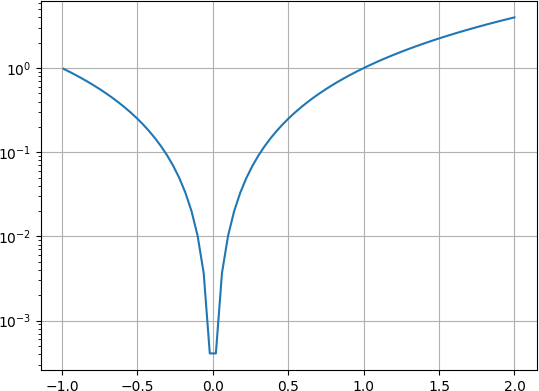

In [5]:
@SliceablePlot.decorate
def plotF(_slice):
    n = 100; r = k1lib.Range(-2, 2)
    x = np.linspace(*r, n)
    _slice = r.toRange(k1lib.Range(n), r.bound(_slice)).slice_
    plt.plot(x[_slice], (x**2)[_slice])
plotF()[-1:].grid(True).yscale("log").__repr__(False)
im = plt.gcf() | cli.toImg(); im | cli.toBytes() | cli.file("../docs/images/SliceablePlot.png"); im

In [6]:
#export
def plotSegments(x:List[float], y:List[float], states:List[int], colors:List[str]=None):
    """Plots a line graph, with multiple segments with different colors.

Idea is, you have a normal line graph, but you want to color parts of
the graph red, other parts blue. Then, you can pass a "state" array, with
the same length as your data, filled with ints, like this::

    y = np.array([ 460800,  921600,  921600, 1445888, 1970176, 1970176, 2301952,
           2633728, 2633728, 3043328, 3452928, 3452928, 3457024, 3461120,
           3463680, 3463680, 3470336, 3470336, 3467776, 3869184, 3865088,
           3865088, 3046400, 2972672, 2972672, 2309632, 2504192, 2504192,
           1456128, 1393664, 1393664,  472576])
    s = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
           1, 0, 0, 1, 0, 0, 1, 0, 0, 1])
    plotSegments(None, y, s, colors=["tab:blue", "tab:red"])
    
.. image:: images/plotSegments.png

:param x: (nullable) list of x coordinate at each point
:param y: list of y coordinates at each point
:param states: list of color at each point
:param colors: string colors (matplotlib color strings) to display for each states"""
    if x is None: x = range(len(y))
    if colors is None: colors = ["tab:blue", "tab:red", "tab:green", "tab:orange", "tab:purple", "tab:brown"][:len(x)]
    _x = []; _y = []; state = -1; count = -1 # stretchs, and bookkeeping nums
    lx = None; ly = None # last x and y from last stretch, for plot autocompletion
    while count + 1 < len(x):
        count += 1
        if state != states[count]:
            if len(_x) > 0 and state >= 0:
                if lx != None: _x = [lx] + _x; _y = [ly] + _y
                plt.plot(_x, _y, colors[state]); lx = _x[-1]; ly = _y[-1]
            _x = [x[count]]; _y = [y[count]]; state = states[count]
        else: _x.append(x[count]); _y.append(y[count])
    if len(_x) > 0 and state >= 0:
        if lx != None: _x = [lx] + _x; _y = [ly] + _y
        plt.plot(_x, _y, colors[state])

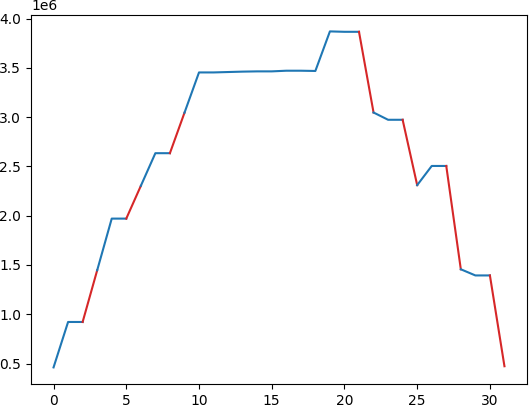

In [7]:
y = np.array([ 460800,  921600,  921600, 1445888, 1970176, 1970176, 2301952,
       2633728, 2633728, 3043328, 3452928, 3452928, 3457024, 3461120,
       3463680, 3463680, 3470336, 3470336, 3467776, 3869184, 3865088,
       3865088, 3046400, 2972672, 2972672, 2309632, 2504192, 2504192,
       1456128, 1393664, 1393664,  472576])
s = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1])
plotSegments(None, y, s, colors=["tab:blue", "tab:red"])
im = plt.gcf() | cli.toImg(); im | cli.toBytes() | cli.file("../docs/images/plotSegments.png"); im

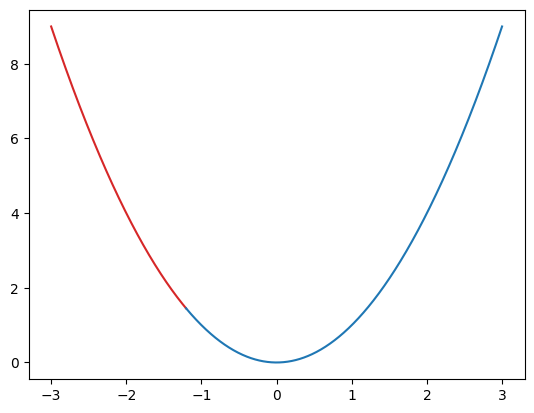

In [8]:
x = np.linspace(-3, 3, 1000)
states = np.zeros(1000, dtype=int); states[:300] = 1
colors = ["tab:blue", "tab:red"]
plotSegments(x, x**2, states)
#plt.show()

In [9]:
#export
class _Carousel:
    def __init__(self, searchMode, imgs, titles): self.searchMode = searchMode; self.titles = titles; self.imgs:List[Tuple[str, str]] = imgs # Tuple[format, base64 img]
    def _repr_html_(self):
        idx = Carousel._idx(); pre = f"k1c_{idx}"; searchMode = self.searchMode
        imgs = self.imgs | cli.apply(lambda x: f"`{x}`") | cli.deref(); n = len(imgs)
        titles = self.titles | cli.apply(lambda x: f"`{x}`") | cli.deref()
        if searchMode > 0: searchBar = f"<input type='text' value='' id='{pre}_search' placeholder='Search in {'content' if searchMode == 1 else 'header'}' style='padding: 4px 4px'>"
        else: searchBar = ""
        if n > 0: contents = imgs | cli.apply(k1lib.decode) | cli.insertIdColumn() | ~cli.apply(lambda idx, html: f"<div id='{pre}_content{idx}'>{html}</div>") | cli.deref() | cli.join('\n')
        else: contents = "(no pages or images are found)"
        #imgs = [f"\"<img alt='' src='data:image/{fmt};base64, {img}' />\"" for fmt, img in self.imgs]
        html = f"""<!-- k1lib.Carousel start -->
<style>
    .{pre}_btn {{
        cursor: pointer; padding: 6px 12px; /*background: #9e9e9e;*/ background-color: #eee;
        margin-right: 8px; color: #000; box-shadow: 0 3px 5px rgb(0,0,0,0.3); border-radius: 18px;
        user-select: none; -webkit-user-select: none; /* Safari */ -ms-user-select: none; /* IE 10+ */
    }}
    .{pre}_btn:hover {{ box-shadow: box-shadow: 0 3px 10px rgb(0,0,0,0.6); background: #4caf50; color: #fff; }}
</style>
{searchBar}
<div>
    <div style="display: flex; flex-direction: row; padding: 8px">
        <div id="{pre}_prevBtn_10" class="{pre}_btn">&#60;10</div>
        <div id="{pre}_prevBtn" class="{pre}_btn">Prev</div>
        <div id="{pre}_nextBtn" class="{pre}_btn">Next</div>
        <div id="{pre}_nextBtn_10" class="{pre}_btn">10&#62;</div>
    </div>
    <div id="{pre}_status" style="padding: 10px"></div>
</div>
<div id="{pre}_imgContainer">{contents}</div>
<script>
    {pre}_allImgs = [{','.join(imgs)}]; {pre}_imgs = [...Array({pre}_allImgs.length).keys()]; // index of all available images. If searching for something then it will be a subset of allImgs
    {pre}_searchMode = {searchMode}; {pre}_titles = [{','.join(titles)}]; {pre}_imgIdx = 0; // n-th element of pre_imgs, not of pre_allImgs
    function {pre}_show(i) {{ document.querySelector(`#{pre}_content${{i}}`).style.display = "block"; }} // i here is allImgs index, not of imgs
    function {pre}_hide(i) {{ document.querySelector(`#{pre}_content${{i}}`).style.display = "none";  }} // i here is allImgs index, not of imgs
    function {pre}_updatePageCount() {{
        let n = {pre}_imgs.length;
        if (n > 0) document.querySelector("#{pre}_status").innerHTML = "Page: " + ({pre}_imgIdx + 1) + "/" + n;
        else document.querySelector("#{pre}_status").innerHTML = "Page: 0/0"
    }}
    function {pre}_display() {{
        let n = {pre}_imgs.length;
        for (let i = 0; i < {n}; i++) {pre}_hide(i);
        if (n > 0) {pre}_show({pre}_imgs[{pre}_imgIdx]);
        {pre}_updatePageCount();
    }};
    document.querySelector("#{pre}_prevBtn")   .onclick = () => {{ {pre}_imgIdx -= 1;  {pre}_imgIdx = Math.max({pre}_imgIdx, 0); {pre}_display(); }};
    document.querySelector("#{pre}_prevBtn_10").onclick = () => {{ {pre}_imgIdx -= 10; {pre}_imgIdx = Math.max({pre}_imgIdx, 0); {pre}_display(); }};
    document.querySelector("#{pre}_nextBtn")   .onclick = () => {{ {pre}_imgIdx += 1;  {pre}_imgIdx = Math.min({pre}_imgIdx, {pre}_imgs.length - 1); {pre}_display(); }};
    document.querySelector("#{pre}_nextBtn_10").onclick = () => {{ {pre}_imgIdx += 10; {pre}_imgIdx = Math.min({pre}_imgIdx, {pre}_imgs.length - 1); {pre}_display(); }};
    if ({pre}_searchMode > 0) {{
        {pre}_searchInp = document.querySelector("#{pre}_search");
        {pre}_searchInp.oninput = (value) => {{
            const val = {pre}_searchInp.value;
            {pre}_imgs = ({pre}_searchMode === 1 ? {pre}_allImgs : {pre}_titles).map((e, i) => [window.atob(e).includes(val), i]).filter(e => e[0]).map(e => e[1]);
            {pre}_imgIdx = 0;; {pre}_display();
        }}
    }}
    {pre}_display();
</script><!-- k1lib.Carousel end -->"""
        return html
class Carousel(cli.BaseCli):
    _idx = k1lib.AutoIncrement.random()
    def __init__(self, searchMode:int=0):
        """Creates a new Carousel that can flip through a list of images/html.
Will even work even when you export the notebook as html. Example::

    x = np.linspace(-2, 2); plt.plot(x, x ** 2); im1 = plt.gcf() | toImg()
    x = np.linspace(-1, 3); plt.plot(x, x ** 2); im2 - plt.gcf() | toImg()
    im3 = "<h1>abc</h1><div>Some content</div>" # can add html
    [im1, im2, im3] | viz.Carousel() # displays in notebook cell

.. image:: images/carousel.png

There's also a builtin search functionality that works like this::

    [
        "<h1>abc</h1><div>Some content 1</div>",
        "<h1>def</h1><div>Some other content 2</div>",
        "<h1>ghi</h1><div>Another content 3</div>",
    ] | viz.Carousel(searchMode=1)

    [
        ["<h1>abc</h1>", "<div>Some content 1</div>"],
        ["<h1>def</h1>", "<div>Some other content 2</div>"],
        ["<h1>ghi</h1>", "<div>Another content 3</div>"],
    ] | viz.Carousel(searchMode=2)

The first mode will search for some text inside the html content. The second mode
will search inside the title only, that means it's expecting to receive Iterator[title, html/img]

:param imgs: List of initial images. Can add more images later on by using :meth:`__ror__`
:param searchMode: 0 for no search, accepts Iterator[html/img],
    1 for search content, accepts Iterator[html/img],
    2 for search title, accepts Iterator[title, html/img]
"""
        self.searchMode = searchMode
    def _process(self, e):
        if isinstance(e, str): return f"{e}"
        elif hasPIL and isinstance(e, PIL.Image.Image): return f"<img alt='' style='max-width: 100%' src='data:image/png;base64, {base64.b64encode(e | cli.toBytes()).decode()}' />"
        else: raise Exception(f"Content is not a string nor a PIL image. Can't make a Carousel out of this unknown type: {type(e)}")
    def __ror__(self, it):
        imgs = []; titles = []; searchMode = self.searchMode
        if searchMode == 0 or searchMode == 1:
            for e in it: imgs.append(k1lib.encode(self._process(e)))
        elif searchMode == 2:
            for title, e in it:
                if not isinstance(title, str): raise Exception("Title is not a string. Can't perform search")
                imgs.append(k1lib.encode(title+self._process(e))); titles.append(k1lib.encode(title))
        else: raise Exception(f"Invalid searchMode: {searchMode}")
        return _Carousel(searchMode, imgs, titles)
    def _jsF(self, meta):
        if self.searchMode != 0: raise Exception("viz.Carousel._jsF() does not support .searchMode!=0. You're using the JS transpiler anyway, you can trivially build your own, more complex search engine!")
        fIdx = cli.init._jsFAuto(); dataIdx = cli.init._jsDAuto(); imgIdx = cli.init._jsDAuto(); pre = cli.init._jsDAuto()
        return f"""
//k1_moveOutStart{pre}_stack = [0];//k1_moveOutEnd
{fIdx} = ({dataIdx}) => {{
    if (window.{pre}_counter) window.{pre}_counter++; else window.{pre}_counter = 1;
    {pre}_stack[window.{pre}_counter] = btoa(JSON.stringify({dataIdx})); return unescape(`<!-- k1lib.Carousel start -->
<style>
    .{pre}_btn {{
        cursor: pointer; padding: 6px 12px; background-color: #eee; margin-right: 8px; color: #000; box-shadow: 0 3px 5px rgb(0,0,0,0.3);
        border-radius: 18px; user-select: none; -webkit-user-select: none; /* Safari */ -ms-user-select: none; /* IE 10+ */
    }}
    .{pre}_btn:hover {{ box-shadow: 0 3px 10px rgb(0,0,0,0.6); background: #4caf50; color: #fff; }}
</style>
<div>
    <div style="display: flex; flex-direction: row; padding: 8px">
        <div id="{pre}_prevBtn" class="{pre}_btn">Prev</div>
        <div id="{pre}_nextBtn" class="{pre}_btn">Next</div>
    </div>
    <div id="{pre}_status" style="padding: 10px"></div>
</div>
<div id="{pre}_imgContainer"></div>
%3Cscript%3E
    (async () => {{
        const {pre}_imgsData = JSON.parse(atob("${{{pre}_stack[window.{pre}_counter]}}"));
        const {pre}_n = {pre}_imgsData.length; {pre}_imgIdx = 0; // current image that's displayed
        let {pre}_imgLoadedIdx = 0; // img ids lower than this is loaded and can be displayed right away, else it should be appended
        {pre}_imgContainer = document.querySelector("#{pre}_imgContainer");
        function {pre}_updatePageCount() {{
            if ({pre}_n > 0) document.querySelector("#{pre}_status").innerHTML = "Page: " + ({pre}_imgIdx + 1) + "/" + {pre}_n;
            else document.querySelector("#{pre}_status").innerHTML = "Page: 0/0"
        }}
        function {pre}_display() {{
            while ({pre}_imgIdx >= {pre}_imgLoadedIdx) {{ // some pages not loaded yet, let's load them up
                const elem = document.createElement("div"); elem.id = "{pre}_content" + {pre}_imgLoadedIdx;
                elem.style.display = "none"; elem.innerHTML = {pre}_imgsData[{pre}_imgLoadedIdx];
                {pre}_imgContainer.appendChild(elem); {pre}_imgLoadedIdx++;
                setTimeout(() => {{ for (const script of elem.getElementsByTagName("script")) eval(script.innerHTML); }}, 100);
            }}
            for (let i = 0; i < {pre}_imgLoadedIdx; i++) document.querySelector("#{pre}_content" + i).style.display = "none";
            if ({pre}_n > 0) document.querySelector("#{pre}_content" + {pre}_imgIdx).style.display = "block";
            {pre}_updatePageCount();
        }};
        document.querySelector("#{pre}_prevBtn").onclick = () => {{ {pre}_imgIdx -= 1; {pre}_imgIdx = Math.max({pre}_imgIdx, 0);           {pre}_display(); }};
        document.querySelector("#{pre}_nextBtn").onclick = () => {{ {pre}_imgIdx += 1; {pre}_imgIdx = Math.min({pre}_imgIdx, {pre}_n - 1); {pre}_display(); }};
        {pre}_display();
    }})();
%3C/script%3E`); }}""", fIdx
k1lib.cli.init.addAtomic(Carousel)

In [10]:
import IPython
[] | Carousel()

In [11]:
[["abc", "def"], ["123", "456"]] | cli.apply(Carousel() | cli.toHtml()) | cli.join("\n") | cli.aS(IPython.display.HTML)

In [12]:
[
    "<h1>abc</h1><div>Some content 1</div>",
    "<h1>def</h1><div>Some other content 2</div>",
    "<h1>ghi</h1><div>Another content 3</div>",
] | Carousel(searchMode=1)

In [13]:
[
    ["<h1>abc</h1>", "<div>Some content 1</div>"],
    ["<h1>def</h1>", "<div>Some other content 2</div>"],
    ["<h1>ghi</h1>", "<div>Another content 3</div>"],
] | Carousel(searchMode=2)

In [14]:
["abc", "def"] | Carousel()
x = np.linspace(-2, 2); plt.plot(x, x ** 2); im1 = plt.gcf() | cli.toImg()
x = np.linspace(-1, 3); plt.plot(x, x ** 2); im2 = plt.gcf() | cli.toImg()
im3 = "<h1>abc</h1><div>Some content</div>"
[im1, im2, im3] | Carousel()

In [15]:
["1", "2"] | (cli.toJsFunc() | Carousel()) | cli.op().interface()

In [16]:
#export
class Toggle(cli.BaseCli):
    _idx = k1lib.AutoIncrement.random()
    def __init__(self):
        """Button to toggle whether the content is displayed or
not. Useful if the html content is very big in size. Example::

    x = np.linspace(-2, 2); plt.plot(x, x ** 2)
    plt.gcf() | toImg() | toHtml() | viz.Toggle()

This will plot a graph, then create a button where you can toggle the image's visibility"""
        self._enteredRor = False; self.content:str = "" # html string
    def __ror__(self, it): self._enteredRor = True; self.content = it if isinstance(it, str) else it | cli.toHtml(); return self
    def __or__(self, it): return it.__ror__(self) if self._enteredRor else super().__or__(it) # see discussion on Carousel() class
    def _repr_html_(self):
        pre = f"k1t_{Toggle._idx()}"; html = f"""<!-- k1lib.Toggle start -->
<style>
    #{pre}_btn {{
        cursor: pointer; padding: 6px 12px;
        background: #eee; margin-right: 5px;
        color: #000; user-select: none; border-radius: 18px;
        -webkit-user-select: none; /* Safari */
        -ms-user-select: none; /* IE 10+ */
        box-shadow: 0 3px 5px rgb(0,0,0,0.3);
    }}
    #{pre}_btn:hover {{ box-shadow: 0 3px 5px rgb(0,0,0,0.6); background: #4caf50; color: #fff; }}
</style>
<div>
    <div style="display: flex; flex-direction: row; padding: 4px">
        <div id="{pre}_btn">Show content</div>
        <div style="flex: 1"></div>
    </div>
    <div id="{pre}_content" style="display: none; margin-top: 12px">{self.content}</div>
</div>
<script>
    {pre}_btn = document.querySelector("#{pre}_btn"); {pre}_displayed = false;
    {pre}_content = document.querySelector("#{pre}_content");
    {pre}_btn.onclick = () => {{
        {pre}_displayed = !{pre}_displayed;
        {pre}_btn.innerHTML = {pre}_displayed ? "Hide content" : "Show content";
        {pre}_content.style.display = {pre}_displayed ? "block" : "none";
    }};
</script>
<!-- k1lib.Toggle end -->"""
        return html
    def _jsF(self, meta):
        fIdx = cli.init._jsFAuto(); dataIdx = cli.init._jsDAuto(); pre = cli.init._jsDAuto()
        return f"""{fIdx} = ({dataIdx}) => {{
        return unescape(`
<!-- k1lib.Toggle start -->
<style>
    #{pre}_btn {{
        cursor: pointer; padding: 6px 12px;
        background: #eee; margin-right: 5px;
        color: #000; user-select: none; border-radius: 18px;
        -webkit-user-select: none; /* Safari */
        -ms-user-select: none; /* IE 10+ */
        box-shadow: 0 3px 5px rgb(0,0,0,0.3);
    }}
    #{pre}_btn:hover {{
        box-shadow: 0 3px 5px rgb(0,0,0,0.6);
        background: #4caf50; color: #fff;
    }}
</style>
<div>
    <div style="display: flex; flex-direction: row; padding: 4px">
        <div id="{pre}_btn">Show content</div>
        <div style="flex: 1"></div>
    </div>
    <div id="{pre}_content" style="display: none; margin-top: 12px">${{{dataIdx}}}</div>
</div>
%3Cscript%3E
    (async () => {{
        {pre}_btn = document.querySelector("#{pre}_btn");
        {pre}_content = document.querySelector("#{pre}_content");

        {pre}_displayed = false;
        {pre}_btn.onclick = () => {{
            {pre}_displayed = !{pre}_displayed;
            {pre}_btn.innerHTML = {pre}_displayed ? "Hide content" : "Show content";
            {pre}_content.style.display = {pre}_displayed ? "block" : "none";
        }};
    }})();
%3C/script%3E`) }}
<!-- k1lib.Toggle end -->""", fIdx
k1lib.cli.init.addAtomic(Toggle)

In [17]:
x = np.linspace(-2, 2); plt.plot(x, x ** 2)
plt.gcf() | cli.toImg() | cli.toHtml() | Toggle()

In [18]:
#export
def ToggleImage():
    """This function is sort of legacy. It's just ``img | toHtml() | viz.Toggle()`` really"""
    return cli.toHtml() | Toggle()

In [19]:
x = np.linspace(-2, 2); plt.plot(x, x ** 2)
plt.gcf() | cli.toImg() | ToggleImage()

In [20]:
"abc" | (cli.toJsFunc() | Toggle()) | cli.op().interface()

In [21]:
#export
class Html(str):
    """A string that will display rich html to a notebook.
Example::

    s = "Just a <b>regular</b> string"
    h = viz.Html(s) # this is an instance of viz.Html, but it's also still a string, as viz.Html subclasses str!
    h               # running this in a notebook cell will display out the html
"""
    def _repr_html_(self): return self

In [22]:
#export
class Scroll(cli.BaseCli):
    def __init__(self, height=300):
        """Creates a new preview html component. If content
is too long, then it will only show the first 500px, then
have a button to expand and view the rest. Example::

    x = np.linspace(-2, 2); plt.plot(x, x ** 2)
    plt.gcf() | toImg() | toHtml() | viz.Scroll()

This will plot a preview of a graph
:param height: height of the parent container"""
        self.height = height
    def __ror__(self, it): return Html(f"""<div style="max-height: {self.height}px; overflow-y: auto">{it}</div>""")
    def _jsF(self, meta):
        fIdx = cli.init._jsFAuto(); dataIdx = cli.init._jsDAuto(); pre = cli.init._jsDAuto()
        return f"""{fIdx} = ({dataIdx}) => {{ return unescape(`<div style="max-height: {self.height}px; overflow-y: auto">${{{dataIdx}}}</div>`); }}""", fIdx
k1lib.cli.init.addAtomic(Scroll)

In [23]:
s = """<h1>The standard Lorem Ipsum passage, used since the 1500s</h1>
<div>"Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."</div>
<h1>Section 1.10.32 of "de Finibus Bonorum et Malorum", written by Cicero in 45 BC</h1>
<div>"Sed ut perspiciatis unde omnis iste natus error sit voluptatem accusantium doloremque laudantium, totam rem aperiam, eaque ipsa quae ab illo inventore veritatis et quasi architecto beatae vitae dicta sunt explicabo. Nemo enim ipsam voluptatem quia voluptas sit aspernatur aut odit aut fugit, sed quia consequuntur magni dolores eos qui ratione voluptatem sequi nesciunt. Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, consectetur, adipisci velit, sed quia non numquam eius modi tempora incidunt ut labore et dolore magnam aliquam quaerat voluptatem. Ut enim ad minima veniam, quis nostrum exercitationem ullam corporis suscipit laboriosam, nisi ut aliquid ex ea commodi consequatur? Quis autem vel eum iure reprehenderit qui in ea voluptate velit esse quam nihil molestiae consequatur, vel illum qui dolorem eum fugiat quo voluptas nulla pariatur?"</div>
"""
s | Scroll()

'<div style="max-height: 300px; overflow-y: auto"><h1>The standard Lorem Ipsum passage, used since the 1500s</h1>\n<div>"Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum."</div>\n<h1>Section 1.10.32 of "de Finibus Bonorum et Malorum", written by Cicero in 45 BC</h1>\n<div>"Sed ut perspiciatis unde omnis iste natus error sit voluptatem accusantium doloremque laudantium, totam rem aperiam, eaque ipsa quae ab illo inventore veritatis et quasi architecto beatae vitae dicta sunt explicabo. Nemo enim ipsam voluptatem quia voluptas sit aspernatur aut odit aut fugit, sed quia consequuntur magni dolores eos qui ratione voluptatem sequi nesciunt. Neque porro quisquam est, qui dolorem ipsum quia dolor sit amet, consectetur, adipisci velit, sed quia non numquam eius modi tempora incidunt ut labore et dolore magnam aliquam quaerat voluptatem. Ut enim ad minima veniam, quis nostrum exercitationem ullam corporis suscipit laboriosam, nisi ut aliquid ex ea commodi consequatur? Quis autem vel eum iure reprehenderit qui in ea voluptate velit esse quam nihil molestiae consequatur, vel illum qui dolorem eum fugiat quo voluptas nulla pariatur?"</div>\n</div>'

In [24]:
import html
[s, html.escape("".join(reversed([*s])))] | cli.apply(Scroll() | cli.toHtml()) | Carousel()

In [25]:
s | (cli.toJsFunc() | Scroll()) | cli.op().interface()

In [26]:
#export
def confusionMatrix(matrix:torch.Tensor, categories:List[str]=None, **kwargs):
    """Plots a confusion matrix. Example::

    k1lib.viz.confusionMatrix(torch.rand(5, 5), ["a", "b", "c", "d", "e"])

.. image:: images/confusionMatrix.png

:param matrix: 2d matrix of shape (n, n)
:param categories: list of string categories
:param kwargs: keyword args passed into :meth:`plt.figure`"""
    if isinstance(matrix, torch.Tensor): matrix = matrix.numpy()
    if categories is None: categories = [f"{e}" for e in range(len(matrix))]
    fig = plt.figure(**{"dpi":100, **kwargs}); ax = fig.add_subplot(111)
    cax = ax.matshow(matrix); fig.colorbar(cax)
    with k1lib.ignoreWarnings():
        ax.set_xticklabels([''] + categories, rotation=90)
        ax.set_yticklabels([''] + categories)
    # Force label at every tick
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax.xaxis.set_label_position('top')
    plt.xlabel("Predictions"); plt.ylabel("Ground truth")

In [27]:
confusionMatrix(torch.rand(5, 5), ["a", "b", "c", "d", "e"])
im = plt.gcf() | cli.toImg(); Carousel([im])
im | cli.toBytes() | cli.file("../docs/images/confusionMatrix.png")

TypeError: RandomClass() takes no arguments

In [28]:
#export
def FAnim(fig, f, frames, *args, **kwargs):
    """Matplotlib function animation, 60fps. Example::

    # line below so that the animation is displayed in the notebook. Included in :mod:`k1lib.imports` already, so you don't really have to do this!
    plt.rcParams["animation.html"] = "jshtml"
    x = np.linspace(-2, 2); y = x**2
    fig, ax = plt.subplots()
    plt.close() # close cause it'll display 1 animation, 1 static if we don't do this
    def f(frame):
        ax.clear()
        ax.set_ylim(0, 4); ax.set_xlim(-2, 2)
        ax.plot(x[:frame], y[:frame])
    k1lib.FAnim(fig, f, len(x)) # plays animation in cell

:param fig: figure object from `plt.figure(...)` command
:param f: function that accepts 1 frame from `frames`.
:param frames: number of frames, or iterator, to pass into function"""
    return partial(mpl.animation.FuncAnimation, interval=1000/30)(fig, f, frames, *args, **kwargs)

In [29]:
plt.rcParams["animation.html"] = "jshtml"
x = np.linspace(-2, 2); y = x**2; fig, ax = plt.subplots(); plt.close() # close cause it'll display 1 animation, 1 static if we don't do this
def f(frame): ax.clear(); ax.set_ylim(0, 4); ax.set_xlim(-2, 2); ax.plot(x[:frame], y[:frame])
FAnim(fig, f, len(x)); # plays animation in cell

/home/quang/miniforge3/lib/python3.12/site-packages/matplotlib/animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [30]:
#export
from k1lib.cli import op
def mask(img:torch.Tensor, act:torch.Tensor) -> torch.Tensor:
    """Shows which part of the image the network is focusing on.

:param img: the image, expected to have dimension of (3, h, w)
:param act: the activation, expected to have dimension of (x, y), and with
    elements from 0 to 1."""
    *_, h, w = img.shape
    mask = act[None,] | nn.AdaptiveAvgPool2d([h//16, w//16]) | nn.AdaptiveAvgPool2d([h//8, w//8]) | nn.AdaptiveAvgPool2d([h, w])
    return mask * img | op().permute(1, 2, 0)

In [31]:
#export
class PDF(object):
    def __init__(self, pdf:str=None, size=(700,500)):
        """Displays pdf in the notebook.
Example::

    viz.PDF("a.pdf")
    "a.pdf" | viz.PDF()
    
    viz.PDF("a.pdf", (700, 500))
    "a.pdf" | viz.PDF(size=(700, 500))

If you're exporting this notebook as html, then you have to make sure
you place the generated html file in the correct directory so that it
can reference those pdf files.

:param pdf: relative path to pdf file"""
        self.pdf = pdf; self.size = size
    def __ror__(self, pdf): self.pdf = pdf; return self
    def _repr_html_(self): return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)
    def _repr_latex_(self): return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

In [32]:
#export
class onload(cli.BaseCli):
    def __init__(self):
        """Returns html code that will run the captured clis when that html is loaded.
Example::

    3 | (toJsFunc() | (viz.onload() | aS("x+3"))) | op().interface()

This displays html that will execute "x+3", then inject it into the main body.
At first glance, this seems useless. A much simpler solution exists::

    3 | (toJsFunc() | aS("x+3")) | op().interface()

This would pretty much do the exact same thing. But there's a subtle difference.
The jsFunc output of the first line (the one with onload()) is some complex html,
and of the second line (without onload()) is just a single number. This is useful
in cases where you don't want to render something right away (as that can take
time/space), but want to defer rendering till later. This is roughly what the first
line generates this html:

.. code-block:: html

    <div id="content">(Loading...)</div>
    <script>
        const data = 3;
        const customFunction = (x) => x+3;
        function onload() { document.querySelector("#content").innerHTML = customFunction(data); }
        onload();
    </script>

While the second line generates this html:

.. code-block:: html

    6

These html is returned by the blocks ``(viz.onload() | aS("x+3"))`` and ``aS("x+3")``
in JS, respectively.

The value of this is that your custom function might do something that generates a
whole bunch of html (like fetching an image somewhere, then return the base64-encoded
image tag). If you were to do it the normal way, then you would execute your function,
return the giant html to display. Meanwhile, if you use this cli, then when you're
moving html around, it's relatively lightweight, and only when that html is embedded
into a page will your custom function captured by :class:`onload` execute, and display
outwards.

Honestly this feels like another implementation of :class:`~k1lib.cli.kjs.toJsFunc`
"""
        super().__init__(capture=True)
    def __ror__(self, it:str):
        jsF = it | (cli.toJsFunc() | self.capturedSerial); pre = cli.init._jsDAuto() # this impl below doesn't quite do what this cli claims to do, so throws error for now
        return Html(f"""<div id='{pre}_div'>(Loading...)</div><script>{jsF.fn}; setTimeout(async () => {{ document.querySelector('#{pre}_div').innerHTML = await {jsF.fIdx}(); }}, 10);</script>""")
    def _jsF(self, meta):
        fIdx = cli.init._jsFAuto(); dataIdx = cli.init._jsDAuto(); pre = cli.init._jsDAuto();
        header, fn, _async = k1lib.kast.asyncGuard(self.capturedSerial._jsF(meta))
        return f"""//k1_moveOutStart{dataIdx} = [-1];//k1_moveOutEnd
{fIdx} = (x) => {{ // returns html string that will run the function on load
    if (window.{fIdx}_counter) window.{fIdx}_counter++; else window.{fIdx}_counter = 1; {dataIdx}[window.{fIdx}_counter] = x;
    {header}; window.{fn} = {fn};
    return unescape(`<div id='{pre}_${{window.{fIdx}_counter}}_div'>(Loading...)</div>
        %3Cscript%3EsetTimeout({'async ' if _async else ''}() => {{
            console.log("viz.onload() executed"); document.querySelector('#{pre}_${{window.{fIdx}_counter}}_div').innerHTML = {'await ' if _async else ''}{fn}({dataIdx}[${{window.{fIdx}_counter}}])
        }}, 100);%3C/script%3E`);
}};""", fIdx

In [33]:
["abc", 1] | (onload() | cli.join(":"))

'<div id=\'_jsD_571_1736131716_17_div\'>(Loading...)</div><script>//k1_moveOutStart\n\n//k1_moveOutEnd\n\n_jsD_571_1736131716_16 = { inputData: ["abc", 1], reload: null };\nasync function _jsF_536_1736131716_15() {\n    _jsF_536_1736131716_14 = (_jsD_571_1736131716_15) => _jsD_571_1736131716_15.join(":")\n    _jsF_536_1736131716_13 = (_jsD_571_1736131716_14) => { return _jsF_536_1736131716_14(_jsD_571_1736131716_14); };\n    _jsF_536_1736131716_12 = (_jsD_571_1736131716_13) => { return _jsF_536_1736131716_13(_jsD_571_1736131716_13); };; return _jsF_536_1736131716_12(_jsD_571_1736131716_16.inputData); }; setTimeout(async () => { document.querySelector(\'#_jsD_571_1736131716_17_div\').innerHTML = await _jsF_536_1736131716_15(); }, 10);</script>'

In [34]:
#export
icons = {"copy": '<svg xmlns="http://www.w3.org/2000/svg" height="24" viewBox="0 -960 960 960" width="24"><path d="M360-240q-33 0-56.5-23.5T280-320v-480q0-33 23.5-56.5T360-880h360q33 0 56.5 23.5T800-800v480q0 33-23.5 56.5T720-240H360Zm0-80h360v-480H360v480ZM200-80q-33 0-56.5-23.5T120-160v-560h80v560h440v80H200Zm160-240v-480 480Z"/></svg>',
         "check": '<svg xmlns="http://www.w3.org/2000/svg" height="24" viewBox="0 -960 960 960" width="24"><path d="M382-240 154-468l57-57 171 171 367-367 57 57-424 424Z"/></svg>',
         "delete": '<svg xmlns="http://www.w3.org/2000/svg" height="24" viewBox="0 -960 960 960" width="24"><path d="M280-120q-33 0-56.5-23.5T200-200v-520h-40v-80h200v-40h240v40h200v80h-40v520q0 33-23.5 56.5T680-120H280Zm400-600H280v520h400v-520ZM360-280h80v-360h-80v360Zm160 0h80v-360h-80v360ZM280-720v520-520Z"/></svg>',
         "edit": '<svg xmlns="http://www.w3.org/2000/svg" height="24" viewBox="0 -960 960 960" width="24"><path d="M200-200h57l391-391-57-57-391 391v57Zm-80 80v-170l528-527q12-11 26.5-17t30.5-6q16 0 31 6t26 18l55 56q12 11 17.5 26t5.5 30q0 16-5.5 30.5T817-647L290-120H120Zm640-584-56-56 56 56Zm-141 85-28-29 57 57-29-28Z"/></svg>',
         "download": '<svg xmlns="http://www.w3.org/2000/svg" height="24" viewBox="0 -960 960 960" width="24"><path d="M480-320 280-520l56-58 104 104v-326h80v326l104-104 56 58-200 200ZM240-160q-33 0-56.5-23.5T160-240v-120h80v120h480v-120h80v120q0 33-23.5 56.5T720-160H240Z"/></svg>'}
class Clipboard(cli.BaseCli):
    def __init__(self, msg="Copy to clipboard"):
        """Returns some nice Html of a button that will copy to the
clipboard when the user clicks on it. Example::

    "some data" | viz.Clipboard() # returns html string

:param msg: message on the button"""
        self.msg = msg
    def _scripts(self):
        pre = cli.init._jsDAuto(); return pre, f"""
<div style="display: flex; flex-direction: row; align-items: center; cursor: pointer" onclick='{pre}_clip(event)'>
    <div>{self.msg}</div><span id='{pre}_copy_icon' style='margin-left: 8px; width: 24px; height: 24px'>{icons['copy']}</span>
</div>""", f"""
    {pre}_copyToClipboard = (text) => {{
        let textArea, elem;
        try {{ navigator.clipboard.writeText(text); }} catch (e) {{ // clipboard api only available via https, so fallback to traditional method if https is not available
            textArea = document.createElement("textarea"); textArea.value = text; elem = document.body
            elem.appendChild(textArea); textArea.focus(); textArea.select(); document.execCommand('copy');
        }} finally {{ if (textArea) elem.removeChild(textArea); }} }}
    window.b64toBlob = (b64Data, contentType='', sliceSize=512) => {{
        const byteCharacters = atob(b64Data); const byteArrays = [];
        for (let offset = 0; offset < byteCharacters.length; offset += sliceSize) {{
            const slice = byteCharacters.slice(offset, offset + sliceSize); const byteNumbers = new Array(slice.length);
            for (let i = 0; i < slice.length; i++) byteNumbers[i] = slice.charCodeAt(i);
            const byteArray = new Uint8Array(byteNumbers); byteArrays.push(byteArray);
        }}; return new Blob(byteArrays, {{type: contentType}}); }}
    {pre}_clip = async (e) => {{
        {pre}_copyToClipboard(window.{pre}_it);
        const icon = document.querySelector("#{pre}_copy_icon"); icon.innerHTML = atob('{base64.b64encode(icons['check'].encode()).decode()}');
        setTimeout(() => {{ icon.innerHTML = atob('{base64.b64encode(icons['copy'].encode()).decode()}'); }}, 1000);
    }}"""
    def __ror__(self, it): pre, body, scripts = self._scripts(); return Html(f"""{body}\n<script>{scripts}\n(async () => {{window.{pre}_it = await b64toBlob('{base64.b64encode(it | cli.toBytes()).decode()}').text();}})();\n</script>""")
    def _jsF(self, meta): fIdx = cli.init._jsFAuto(); pre, body, scripts = self._scripts(); return f"""{scripts}\n{fIdx} = (it) => {{ window.{pre}_it = it; return `{body}`; }}""", fIdx

In [35]:
"some data 2" | Clipboard()

'\n<div style="display: flex; flex-direction: row; align-items: center; cursor: pointer" onclick=\'_jsD_571_1736131716_18_clip(event)\'>\n    <div>Copy to clipboard</div><span id=\'_jsD_571_1736131716_18_copy_icon\' style=\'margin-left: 8px; width: 24px; height: 24px\'><svg xmlns="http://www.w3.org/2000/svg" height="24" viewBox="0 -960 960 960" width="24"><path d="M360-240q-33 0-56.5-23.5T280-320v-480q0-33 23.5-56.5T360-880h360q33 0 56.5 23.5T800-800v480q0 33-23.5 56.5T720-240H360Zm0-80h360v-480H360v480ZM200-80q-33 0-56.5-23.5T120-160v-560h80v560h440v80H200Zm160-240v-480 480Z"/></svg></span>\n</div>\n<script>\n    _jsD_571_1736131716_18_copyToClipboard = (text) => {\n        let textArea, elem;\n        try { navigator.clipboard.writeText(text); } catch (e) { // clipboard api only available via https, so fallback to traditional method if https is not available\n            textArea = document.createElement("textarea"); textArea.value = text; elem = document.body\n            elem.appendChild(textArea); textArea.focus(); textArea.select(); document.execCommand(\'copy\');\n        } finally { if (textArea) elem.removeChild(textArea); } }\n    window.b64toBlob = (b64Data, contentType=\'\', sliceSize=512) => {\n        const byteCharacters = atob(b64Data); const byteArrays = [];\n        for (let offset = 0; offset < byteCharacters.length; offset += sliceSize) {\n            const slice = byteCharacters.slice(offset, offset + sliceSize); const byteNumbers = new Array(slice.length);\n            for (let i = 0; i < slice.length; i++) byteNumbers[i] = slice.charCodeAt(i);\n            const byteArray = new Uint8Array(byteNumbers); byteArrays.push(byteArray);\n        }; return new Blob(byteArrays, {type: contentType}); }\n    _jsD_571_1736131716_18_clip = async (e) => {\n        _jsD_571_1736131716_18_copyToClipboard(window._jsD_571_1736131716_18_it);\n        const icon = document.querySelector("#_jsD_571_1736131716_18_copy_icon"); icon.innerHTML = atob(\'PHN2ZyB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMjAwMC9zdmciIGhlaWdodD0iMjQiIHZpZXdCb3g9IjAgLTk2MCA5NjAgOTYwIiB3aWR0aD0iMjQiPjxwYXRoIGQ9Ik0zODItMjQwIDE1NC00NjhsNTctNTcgMTcxIDE3MSAzNjctMzY3IDU3IDU3LTQyNCA0MjRaIi8+PC9zdmc+\');\n        setTimeout(() => { icon.innerHTML = atob(\'PHN2ZyB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMjAwMC9zdmciIGhlaWdodD0iMjQiIHZpZXdCb3g9IjAgLTk2MCA5NjAgOTYwIiB3aWR0aD0iMjQiPjxwYXRoIGQ9Ik0zNjAtMjQwcS0zMyAwLTU2LjUtMjMuNVQyODAtMzIwdi00ODBxMC0zMyAyMy41LTU2LjVUMzYwLTg4MGgzNjBxMzMgMCA1Ni41IDIzLjVUODAwLTgwMHY0ODBxMCAzMy0yMy41IDU2LjVUNzIwLTI0MEgzNjBabTAtODBoMzYwdi00ODBIMzYwdjQ4MFpNMjAwLTgwcS0zMyAwLTU2LjUtMjMuNVQxMjAtMTYwdi01NjBoODB2NTYwaDQ0MHY4MEgyMDBabTE2MC0yNDB2LTQ4MCA0ODBaIi8+PC9zdmc+\'); }, 1000);\n    }\n(async () => {window._jsD_571_1736131716_18_it = await b64toBlob(\'c29tZSBkYXRhIDI=\').text();})();\n</script>'

In [36]:
"some data 3" | (cli.toJsFunc() | Clipboard()) | cli.op().interface()

In [37]:
#export
class Download(cli.BaseCli):
    def __init__(self, fn:str="untitled", msg:str="Download file"):
        """Returns some nice Html of a button that will download
whatever's piped into this into a file. Example::

    "some data" | viz.Download("some_text_file.txt") # returns html string that downloads the file

:param fn: desired file name
:param msg: message on the button"""
        self.fn = fn; self.msg = msg
    def __ror__(self, it):
        pre = cli.init._jsDAuto();
        if isinstance(it, str): it = it.encode()
        if not isinstance(it, bytes): raise Exception("Input has to be string or bytes")
        return Html(f"""
<div style="display: flex; flex-direction: row; align-items: center; cursor: pointer" onclick='{pre}_down(event)'>
    <div>{self.msg}</div><span id='{pre}_down_icon' style='margin-left: 8px; width: 24px; height: 24px'>{icons['download']}</span>
</div>
<script>
    {pre}_down = async (e) => {{
        const url = window.URL.createObjectURL(new Blob([atob("{base64.b64encode(it).decode()}")]));
        const a = document.createElement('a'); a.style.display = 'none'; a.href = url; a.download = {json.dumps(self.fn)};
        document.body.appendChild(a); a.click(); window.URL.revokeObjectURL(url); a.remove();
        const icon = document.querySelector("#{pre}_down_icon"); icon.innerHTML = atob('{base64.b64encode(icons['check'].encode()).decode()}');
        setTimeout(() => {{ icon.innerHTML = atob('{base64.b64encode(icons['download'].encode()).decode()}'); }}, 1000);
    }}
</script>""")

In [38]:
"some content" | Download("somefile.txt")

'\n<div style="display: flex; flex-direction: row; align-items: center; cursor: pointer" onclick=\'_jsD_571_1736131716_22_down(event)\'>\n    <div>Download file</div><span id=\'_jsD_571_1736131716_22_down_icon\' style=\'margin-left: 8px; width: 24px; height: 24px\'><svg xmlns="http://www.w3.org/2000/svg" height="24" viewBox="0 -960 960 960" width="24"><path d="M480-320 280-520l56-58 104 104v-326h80v326l104-104 56 58-200 200ZM240-160q-33 0-56.5-23.5T160-240v-120h80v120h480v-120h80v120q0 33-23.5 56.5T720-160H240Z"/></svg></span>\n</div>\n<script>\n    _jsD_571_1736131716_22_down = async (e) => {\n        const url = window.URL.createObjectURL(new Blob([atob("c29tZSBjb250ZW50")]));\n        const a = document.createElement(\'a\'); a.style.display = \'none\'; a.href = url; a.download = "somefile.txt";\n        document.body.appendChild(a); a.click(); window.URL.revokeObjectURL(url); a.remove();\n        const icon = document.querySelector("#_jsD_571_1736131716_22_down_icon"); icon.innerHTML = atob(\'PHN2ZyB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMjAwMC9zdmciIGhlaWdodD0iMjQiIHZpZXdCb3g9IjAgLTk2MCA5NjAgOTYwIiB3aWR0aD0iMjQiPjxwYXRoIGQ9Ik0zODItMjQwIDE1NC00NjhsNTctNTcgMTcxIDE3MSAzNjctMzY3IDU3IDU3LTQyNCA0MjRaIi8+PC9zdmc+\');\n        setTimeout(() => { icon.innerHTML = atob(\'PHN2ZyB4bWxucz0iaHR0cDovL3d3dy53My5vcmcvMjAwMC9zdmciIGhlaWdodD0iMjQiIHZpZXdCb3g9IjAgLTk2MCA5NjAgOTYwIiB3aWR0aD0iMjQiPjxwYXRoIGQ9Ik00ODAtMzIwIDI4MC01MjBsNTYtNTggMTA0IDEwNHYtMzI2aDgwdjMyNmwxMDQtMTA0IDU2IDU4LTIwMCAyMDBaTTI0MC0xNjBxLTMzIDAtNTYuNS0yMy41VDE2MC0yNDB2LTEyMGg4MHYxMjBoNDgwdi0xMjBoODB2MTIwcTAgMzMtMjMuNSA1Ni41VDcyMC0xNjBIMjQwWiIvPjwvc3ZnPg==\'); }, 1000);\n    }\n</script>'

In [39]:
#export
def qrScanner(fName=None, facing="environment"):
    """Returns some nice Html displaying a live video feed that calls a function when a QR code is identified.
Example::

    ht = viz.qrScanner("qrIdentified")
    viz.Html(ht + "<script>function qrIdentified(data) { console.log("qr: ", data); }</script>")

After executing that in a cell, it should display a live video feed

:param fName: js function name to be triggered
:param facing: 'environment' or 'user', determines the camera location"""
    if not fName: raise Exception("Please specify a JS function name to be called whenever the scanner detected a QR code")
    pre = cli.init._jsDAuto(); return Html(f"""
<video id="{pre}_video" style="max-width: 100%" autoplay></video><canvas id="{pre}_canvas" style="display:none;"></canvas>
<script src="https://static.aigu.vn/jsQR.js"></script>
<script>
    const {pre}_video = document.querySelector("#{pre}_video"); const {pre}_canvas = document.querySelector("#{pre}_canvas"); var {pre}_ctx = {pre}_canvas.getContext('2d');
    navigator.mediaDevices.getUserMedia({{ video: {{ facingMode: '{facing}' }} }})
        .then(function(stream) {{ var video = document.getElementById('{pre}_video'); video.srcObject = stream; video.play(); requestAnimationFrame({pre}_tick); }})
        .catch(function(err) {{ console.error('Error accessing the camera: ', err); }});

    async function {pre}_tick() {{
        {pre}_ctx.drawImage({pre}_video, 0, 0, {pre}_canvas.width, {pre}_canvas.height);
        var imageData = {pre}_ctx.getImageData(0, 0, {pre}_canvas.width, {pre}_canvas.height);
        var code = jsQR(imageData.data, imageData.width, imageData.height);
        if (code) {fName}(code.data); requestAnimationFrame({pre}_tick);
    }}
</script>""")

In [40]:
a = qrScanner("qrIdentified")

In [41]:
#export
def Popup(elem:str, popup:str):
    """Makes an popup appear at the bottom right of an element after clicking on it.
Example::

    a = viz.Popup("<button>abc</button>", "<div>popup content</div>")
    b = f"{a}<pre>some\\nother\\ncontent</pre>" | toHtml()
"""
    pre = cli.init._jsDAuto(); return f"""<div id="{pre}_rel" onclick="{pre}_onclick(this)" style="position:relative;width:min-content">{elem}<div id="{pre}_popup" style="position:absolute;display:none;background:white;padding:12px;box-shadow:rgba(0,0,0,0.15) 1.95px 1.95px 2.6px;border-radius:12px;" tabindex="0">{popup}</div></div>
<script>(async () => {{ window.{pre}_onclick = () => {{ const rel = document.querySelector("#{pre}_rel"); const popup = document.querySelector("#{pre}_popup"); popup.style.left = rel.clientWidth + "px"; popup.style.top = rel.clientHeight + "px"; popup.style.display = "block"; popup.focus(); popup.onblur = () => {{ popup.style.display = "none"; }} }} }})();</script>""" | cli.toHtml()

In [42]:
f"""{Popup("<button>abc</button>", "def")}<pre>some\nother\ncontent</pre>""" | cli.toHtml()

'<div id="_jsD_571_1736131716_24_rel" onclick="_jsD_571_1736131716_24_onclick(this)" style="position:relative;width:min-content"><button>abc</button><div id="_jsD_571_1736131716_24_popup" style="position:absolute;display:none;background:white;padding:12px;box-shadow:rgba(0,0,0,0.15) 1.95px 1.95px 2.6px;border-radius:12px;" tabindex="0">def</div></div>\n<script>(async () => { window._jsD_571_1736131716_24_onclick = () => { const rel = document.querySelector("#_jsD_571_1736131716_24_rel"); const popup = document.querySelector("#_jsD_571_1736131716_24_popup"); popup.style.left = rel.clientWidth + "px"; popup.style.top = rel.clientHeight + "px"; popup.style.display = "block"; popup.focus(); popup.onblur = () => { popup.style.display = "none"; } } })();</script><pre>some\nother\ncontent</pre>'

In [143]:
#export
class Table(cli.BaseCli):
    def __init__(self, headers:"list[str]"=None,
                 onclickFName:str=None, ondeleteFName:str=None, oneditFName:str=None, onclickHeaderFName:str=None,
                 colOpts:"list[list[str]]"=None, sortF:str=None,
                 selectable=False, selectCallback:str=None, height=None, objName:str=None, colsToHide:list[int]=None,
                 perPage:int=None, numRows=None):
        """Returns some nice Html displaying a table.
Example::

    res = enumerate("abcdef") | viz.Table(onclickFName="onclickF", ondeleteFName="deleteF")
    f\"\"\"<script>
        function onclickF(row, i, e) {{ console.log("onclickF: ", row, i, e); }}
        function deleteF(row, i, e) {{ console.log("deleteF: ", row, i, e); }}
    </script>
    {res}\"\"\" | toHtml() # creates html string and displays it in the notebook cell

Normally, if you want to display a plain old table, you can do ``sometable | display()``,
which is the same as ``sometable | head() | pretty() | stdout()``, but that only gives you
a static table. This class will still show the table, but you can specify an "onclickFName"
which the system will call whenever the user clicks on a particular row. If "ondeleteFName"
is specified, then a column full of delete buttons will be injected as the first column,
and if the user clicks on it will execute the function you specified. The example above
should be intuitive enough.

If oneditFName is specified, then it allows editing a row at a time. After the user has
typed in everything, that function will be called, and if successful, will update the
table right away.

There're these available options for each column ("colOpts"):

* ["pad", 10]: padding on all 4 sides, defaulted to 10 if not specified
* "json": if specified, will assume the row element to be a json and make it look nice
* ["jsonWidth", 400]: max width of json fields
* ["jsonHeight", 300]: max height of json fields
* "clipboard": if specified, will copy the contents of the cell to clipboard when user clicks on it

Say you have 3 columns, and you want:

* Column 1: json with max width of 500px, copies its contents to clipboard onclick
* Column 2: nothing special
* Column 3: copies its contents to clipboard onclick

Then "colOpts" should be [["json", ["jsonWidth", 500], "clipboard"], [], ["clipboard"]]

With tables that have complex features, there's also a hidden "{pre}_obj" JS object that has a
bunch of useful functions, as well as callbacks that allows you to do interactive things::

    ui1 = enumerate("abcdef") | viz.Table(objName="something")
    f\"\"\"
        {ui1}
        <script>
            setTimeout(() => something.update([[1, 2], [3, 4], [5, 6]]), 1000); // updates the table's contents after 1 second
            setTimeout(() => console.log(something.data), 3000); // prints the table's data after 3 seconds
        </script>
    \"\"\" | toHtml()

Pagination {pre}_obj values:

* async page_select(pageNum:int): selects a specific page, 0-indexed
* async page_next(): goes to next page
* async page_prev(): goes to previous page
* async page_onselect(pageNum): function that should return list[list[str|int]] for the specific
  page it's on. The returned result will be used to render the table. Don't have to override
  this by default, it will just slice up the incoming data to return the correct page

:param headers: a list of column names
:param onclickFName:       global function that will be called whenever the user clicks on a specific item
:param ondeleteFName:      global function that will be called whenever the user wants to delete a specific row
:param oneditFName:        global function that will be called whenever the user finishes editing a specific row
:param onclickHeaderFName: global function that will be called whenever the user clicks on a specific header
:param colOpts: column options
:param sortF: takes in [table (list[list[str | number]]), col (int)] and returns the sorted table. Can put :data:`True` in for the default sorter
:param selectable: if True, make the row bold when user clicks on it, else don't do that
:param selectCallback: function name to inject into global namespace so as to trigger
:param height: if specified, limits the table height to this many pixels, and add a vertical scrolling bar
:param objName: name of the JS object that contains functions to interact with the table
:param colsToHide: list of column indexes to hide internal selection. Does not cascade to onclickFName
:param perPage: if specified, splits the incoming data into multiple pages, and allow users to navigate around those pages
:param numRows: in pagination mode, this variable will be used to display the initial total number of pages. Purely aestheetic, no function"""
        self.headers = headers; self.onclickFName = onclickFName; self.ondeleteFName = ondeleteFName; self.onclickHeaderFName = onclickHeaderFName
        self.oneditFName = oneditFName; self.colOpts = colOpts; self.sortF = sortF; self.selectable = selectable; self.selectCallback = selectCallback
        self.height = height; self.objName = objName; self.colsToHide = colsToHide or []; self.perPage = perPage; self.numRows = numRows
    def _scripts(self, pre): # common scripts section between __ror__() and _jsF(), include functions exposed to the global js runtime
        height = f"""document.querySelector("#{pre}_tableWrap").scrollTop = e.getBoundingClientRect().top - document.querySelector("#{pre}_table").getBoundingClientRect().top - 80;""" if self.height else ""; selectCallback = f"""
    window.{self.selectCallback} = (predicate) => {{ // scans entire existing table for rows that satify the predicate function. Kinda deprecated function, use {pre}_obj.selectId() instead!
        data = {pre}_obj.data;
        for (let i = 0; i < data.length; i++) document.querySelector("#{pre}_row_" + i).style.backgroundColor = "";
        for (let i = 0; i < data.length; i++) if (predicate(data[i])) {{
            e = document.querySelector("#{pre}_table").querySelector("#{pre}_row_" + i);{height}
            e.style.backgroundColor = "#dddddd"; {pre}_obj.selectedRowId = i; {pre}_obj.selectedRow = data[i]; break
        }}
    }}""" if self.selectCallback else ""; ondeleteFName = self.ondeleteFName; pre_delete = f"""
    {pre}_delete = async (row, i, e) => {{
        if (e) e.stopPropagation();
        try {{ // if the function don't raise any error, then actually delete the element, else just alert the user that the operation failed
            if ({ondeleteFName}.constructor.name === "AsyncFunction") res = await {ondeleteFName}(row, i, e);
            else res = {ondeleteFName}(row, i, e); if (res === "dont_delete") return;
            document.querySelector("#{pre}_row_" + i).remove(); {pre}_obj.data[i] = null;
        }} catch (e) {{ if (e.message !== "\ue000nopropagate") window.alertCallback(e); }}
    }}""" if ondeleteFName else ""; oneditFName = self.oneditFName; pre_edit = f"""
    {pre}_edit = async (row, rowi, e) => {{ // swaps out table contents with input boxes
        if (e) e.stopPropagation(); nodes = Array.from(document.querySelectorAll("#{pre}_row_" + rowi + " > .k1TableElement"));
        for (let i = 0; i < nodes.length; i++) {{
            nodes[i].innerHTML = "<input type='text' class='input input-bordered' />";
            nodes[i].querySelector("input").value = {pre}_obj.data[rowi][i];
            nodes[i].onclick = (e) => {{ if (e) e.stopPropagation(); }}
        }}
        document.querySelector("#{pre}_row_" + rowi + ">.editIcon").innerHTML = "<span style='cursor: pointer' onclick='{pre}_finishedEdit({pre}_obj.data[" + rowi + "], " + rowi + ", event)'></span>"
        document.querySelector("#{pre}_row_" + rowi + ">.editIcon>span").innerHTML = atob('{base64.b64encode(icons['check'].encode()).decode()}')
    }}
    {pre}_finishedEdit = async (row, rowi, e) => {{ // finished editing parts of the table
        if (e) e.stopPropagation(); console.log("finishedEdit:", row, rowi, e);
        nodes  = Array.from(document.querySelectorAll("#{pre}_row_" + rowi + ">.k1TableElement"))
        inputs = Array.from(document.querySelectorAll("#{pre}_row_" + rowi + ">.k1TableElement>input"));
        values = inputs.map((inp) => inp.value);
        try {{ // if the function don't raise any error, then actually registers the element, else just alert the user that the operation failed
            if ({oneditFName}.constructor.name === "AsyncFunction") res = await {oneditFName}(row, values, rowi, e);
            else res = {oneditFName}(row, values, rowi, e);
            for (let i = 0; i < nodes.length; i++) {{ nodes[i].innerHTML = values[i]; }}; {pre}_obj.data[rowi] = values;
            document.querySelector("#{pre}_row_" + rowi + ">.editIcon").innerHTML = "<span style='cursor: pointer' onclick='{pre}_edit({pre}_obj.data[" + rowi + "], " + rowi + ", event)'></span>";
            document.querySelector("#{pre}_row_" + rowi + ">.editIcon>span").innerHTML = atob('{base64.b64encode(icons['edit'].encode()).decode()}');
        }} catch (e) {{ if (e.message !== "\ue000nopropagate") window.alertCallback(e); }}
    }}""" if oneditFName else ""; pre_clip = f"""
    {pre}_clip = async (e, rowi, elemi) => {{
        const value = {pre}_obj.data[rowi][elemi]; {pre}_copyToClipboard((typeof(value) === "string") ? value : JSON.stringify(value), rowi, elemi);
        const icon = document.querySelector("#{pre}_copy_icon_" + rowi + "_" + elemi); icon.innerHTML = atob('{base64.b64encode(icons['check'].encode()).decode()}');
        setTimeout(() => {{ icon.innerHTML = atob('{base64.b64encode(icons['copy'].encode()).decode()}'); }}, 1000);
    }}
    {pre}_copyToClipboard = (text, rowi, elemi) => {{
        let textArea, elem;
        try {{ navigator.clipboard.writeText(text); }} catch (e) {{ // clipboard api only available via https, so fallback to traditional method if https is not available
            textArea = document.createElement("textarea"); textArea.value = text
            elem = document.querySelector("#{pre}_elem_" + rowi + "_" + elemi); elem.appendChild(textArea);
            textArea.focus(); textArea.select(); document.execCommand('copy');
        }} finally {{ if (textArea) elem.removeChild(textArea); }}
    }}""" if self._colOpts_hasClip() else ""
        onclickHeader = ""; headerCommon = f"""let col=null;try{{col=parseInt(e.target.id.split("_").at(-1));}}catch(e){{}}"""
        if self.onclickHeaderFName and not self.sortF: onclickHeader = f"""{headerCommon}{self.onclickHeaderFName}(e, col);"""
        elif self.sortF: onclickHeader = f"{self.onclickHeaderFName}(e, col)" if self.onclickHeaderFName else ""; onclickHeader = f"""
{headerCommon}; let sortF = ({json.dumps(isinstance(self.sortF, str))}) ? {self.sortF} : ((data, col) => {{ return data.toSorted((a,b) => (a[col] === b[col]) ? 0 : ((a[col] > b[col]) ? 1 : -1)); }});
let asc = true; let headerEId = e.target.id; if (e.target.innerHTML.trim().at(-1) == "↑") asc = false;
let newData = sortF({pre}_obj.data.filter((x) => x !== null), col); {pre}_obj.data = asc ? newData : newData.toReversed(); {pre}_obj.renderRaw();
let headerE = document.querySelector("#"+headerEId); headerE.innerHTML = headerE.innerHTML.replaceAll("↑","").replaceAll("↓","").trim() + " " + (asc ? "↑" : "↓");
e.target = headerE; {onclickHeader};"""
        onclickFName = self.onclickFName; pre_select = f"""
    {pre}_select = async (row, i, e, visual=false) => {{ // visual: if true, only update the visuals, else also runs the custom onclickFName function
        if (i < 0) {{ {onclickHeader}return; }}; if (e) e.stopPropagation();
        if ({json.dumps(self.selectable)}) {{
            if ({pre}_obj.selectedRowId >= 0) document.querySelector("#{pre}_row_" + {pre}_obj.selectedRowId).style.backgroundColor = ""; s = document.querySelector("#{pre}_row_" + i).style;
            if ({pre}_obj.selectedRowId === i) {{ s.backgroundColor = ""; {pre}_obj.selectedRowId = -1; {pre}_obj.selectedRow = null; }} else {{ s.backgroundColor = "#dddddd"; {pre}_obj.selectedRowId = i; {pre}_obj.selectedRow = row; }}
        }} if (!visual && {json.dumps(onclickFName)}) {{
            try {{ if ({onclickFName}.constructor.name === "AsyncFunction") await {onclickFName}(row, i, e); else {onclickFName}(row, i, e);
            }} catch (e) {{ if (e.message !== "\ue000nopropagate") window.alertCallback(e); }}
        }}
    }}""" if onclickFName or onclickHeader or self.selectable or self.sortF else ""; return f"""if (!window.alertCallback) window.alertCallback = alert; {selectCallback}{pre_delete}{pre_edit}{pre_clip}{pre_select}"""
    def _paginationHtml(self, pre): return f"""
<style>
    .{pre}_pageGray {{ text-decoration: none; padding: 8px 12px; background: #dbdbdb; color: #878787; border-radius: 4px; transition: background 0.3s; }}
    .{pre}_pageHover {{ cursor: pointer; user-select: none; }} .{pre}_pageHover:hover {{ background: #878787; color: #f0f0f0; }}
</style>
<div style="display: flex; align-items: center; justify-content: center;">
    <div class="{pre}_pagination" style="display: flex; flex-direction: row; align-items: center; list-style-type: none; padding: 0; margin: 0;">
        <div class="{pre}_pageGray {pre}_pageHover" style="margin: 0 5px" onclick="{pre}_obj.page_prev()">&laquo;</div>
        <div id="{pre}_pageNum1" class="{pre}_pageGray" style="margin: 0 5px; background: #878787; color: #f0f0f0; cursor: default">1</div>
        <div style="margin: 0 5px">of</div>
        <div id="{pre}_pageLen1" class="{pre}_pageGray" style="margin: 0 5px; background: #cccccc; color: #4a4a4a; cursor: default">?</div>
        <div class="{pre}_pageGray {pre}_pageHover" style="margin: 0 5px" onclick="{pre}_obj.page_next()">&raquo;</div>
    </div>
    <div style="margin-left: 10px; display: flex; flex-direction: row; align-items: center;">
        <div style="margin: 0 8px">Page </div>
        <select id="{pre}_pageSelect" onchange="onDropdownChange(this)" style="padding: 5px; border-radius: 4px; border: 1px solid #cccccc; cursor: pointer"></select>
        <div id="{pre}_pageLen2" style="margin: 0 8px"> of ?</div>
    </div>
</div>""" if self.perPage else ""
    def _paginationJs(self, pre): return f"""(async () => {{
        document.querySelector("#{pre}_pageSelect").onchange = async (e) => {{ {pre}_obj.page_select(parseInt(document.querySelector("#{pre}_pageSelect").value)); }};
}})();"""
    def __ror__(self, it) -> Html: # so the render function is kinda duplicated. One runs directly in python, and the other runs in js, allowing the table contents to be updated in real time
        headers = self.headers; onclickFName = self.onclickFName; onclickHeaderFName = self.onclickHeaderFName; ondeleteFName = self.ondeleteFName; oneditFName = self.oneditFName; selectable = self.selectable; colOpts = self.colOpts; colsToHide = self.colsToHide
        it = it | cli.deref(2); pre = cli.init._jsUIAuto(); N = len(it);
        try: F = max([len(x) for x in it])
        except: F = len(self.headers) if self.headers else 1000
        colOpts = [] if colOpts is None else list(colOpts)
        for i in range(F-len(colOpts)): colOpts.append([])
        def felem(i, e, rowi):
            if i in colsToHide: return ""
            idx = f"id='{pre}_elem_{rowi}_{i}' class='k1TableElement {pre}_elem'"
            res = [opt[1] for opt in colOpts[i] if not isinstance(opt, str) and opt[0] == "pad"]; pad = res[0] if len(res) > 0 else 10; style = f"position: relative; padding: {pad}px"
            copy = f"<div style='position: absolute; top: 0px; right: 0px'><span id='{pre}_copy_icon_{rowi}_{i}' style='cursor: pointer' onclick='{pre}_clip(event, {rowi}, {i})'>{icons['copy']}</span></div>" if "clipboard" in colOpts[i] and rowi >= 0 else ""
            if "json" in colOpts[i] and rowi >= 0:
                res = [opt[1] for opt in colOpts[i] if not isinstance(opt, str) and opt[0] == "jsonWidth"];  maxWidth  = res[0] if len(res) > 0 else 400
                res = [opt[1] for opt in colOpts[i] if not isinstance(opt, str) and opt[0] == "jsonHeight"]; maxHeight = res[0] if len(res) > 0 else 300
                return f"<td {idx} style='text-align: left; {style}'>{copy}<pre style='max-width: {maxWidth}px; max-height: {maxHeight}px; overflow-x: auto; overflow-y: auto; background-color: transparent'>{html.escape(json.dumps(e, indent=2))}</pre></td>"
            return f"<td {idx} style='{style}'>{copy}{e}</td>"
        def frow(i, row):
            row = [felem(_i, e, i) for _i,e in enumerate(row)]
            if oneditFName: row = ["<td></td>", *row] if i < 0 else [f"<td class='editIcon'><span style='cursor: pointer' onclick='{pre}_edit({pre}_obj.data[{i}], {i}, event)'>{icons['edit']}</span></td>", *row]
            if ondeleteFName: row = ["<td></td>", *row] if i < 0 else [f"<td class='deleteIcon'><span style='cursor: pointer' onclick='{pre}_delete({pre}_obj.data[{i}], {i}, event)'>{icons['delete']}</span></td>", *row]
            sticky = "style='position: sticky; top: 0px; background: white; z-index: 100'" if i < 0 else ""; sig = f"id='{pre}_row_{i}' class='{pre}_row' {sticky}"
            sig = f"<tr {sig} onclick='{pre}_select({pre}_obj.data[{i}], {i}, event)'>" if onclickFName or onclickHeaderFName or selectable or self.sortF else f"<tr {sig} >"; return sig + "".join(row) + "</tr>"
        page1 = it[0:self.perPage] if self.perPage else it
        contents = "".join([frow(i, row) for i,row in ([(-1, headers), *enumerate(page1)] if headers else enumerate(page1))]);
        height = [f"<div id='{pre}_tableWrap' style='max-height:{self.height}px;overflow-y:auto'>", "</div>"] if self.height else ["", ""]
        pageS = f"{self._paginationJs(pre)}; {pre}_obj.page_setup({self.numRows or len(it)});" if self.perPage else ""
        scriptS = f"""<script>{self._js_genFuncs(pre)};{pre}_obj.data = {json.dumps(it)};{self._scripts(pre)};{pageS}</script>""" if self._dynamism("script") or self._dynamism("func") else ""
        return Html(f"""{height[0]}<table id='{pre}_table'>{contents}</table>{height[1]}{self._paginationHtml(pre)}{scriptS}""")
    def _dynamism(self, mode="script"): # whether I need to (loosely) include self._scripts() or self._js_genFuncs() or not
        if mode == "script": return self.onclickHeaderFName or self.onclickFName or self.oneditFName or self.ondeleteFName or self.selectable or self._colOpts_hasClip()
        elif mode == "func": return self.selectCallback or self.objName or self.sortF or self.perPage
        else: raise Exception("Don't have that mode")
    def _js_genFuncs(self, pre, gens=False):
        """You might be asking what the hell is up with this. All of the complexity you see around
is the result of this having to do lots of stuff at the same time. There's the pure python mode, and
there's the JS transpiled version. There's also the requirement of it generating tables that are the
shortest that it can be.

If the user wants a vanilla table, no interactivity, then it should not include any js at all, as
some applications have tons of tables everywhere, like a carousel containing 40 tables and so on.
Including js would really slow rendering down, and that's absolutely terrible.

But if the user wants interactivity, then it will inject in only enough js so that the table will
function normally, and not more, to again reduce global namespace pollution and js interpretation
time. So there are several layers of complexity that this class can generate:
- Layer 1: vanilla table, no JS at all
- Layer 2: table with basic functionalities, like onclick, ondelete, onedit, onclip (dynamism "script")
- Layer 3: table with advanved functionalities, like:
  - Silently updating table contents
  - Programmatically selects a specific row and scroll to that row
  - Has js-accessible table data ({pre}_obj object)
  - Sorts each column

:param gens: whether you *would* like to include JS table-generation functions or not"""
        objNameAssign = f"if (window.{self.objName} != undefined) {{ {pre}_obj.page_onselect = window.{self.objName}.page_onselect; }} else window.{self.objName} = {pre}_obj;" if self.objName else ""; funcDyn = self._dynamism("func"); funcS = f"""
    renderRaw: () => {{ document.querySelector("#{pre}_table").innerHTML = ({json.dumps(self.headers)} ? [[-1, {json.dumps(self.headers)}], ...{pre}_obj.data.map((x,i) => [i,x])] : {pre}_obj.data.map((x,i) => [i,x])).map(([i, row]) => {pre}_frow(i, row)).join(""); }},
    _diff: (oldData, newData) => {{ // returns true if there's a diff
        if (oldData.length !== newData.length) return true;
        for (let i = 0; i < oldData.length; i++) {{
            if (oldData[i] === null || oldData[i] === undefined || oldData[i].length !== newData[i].length) return true;
            for (let j = 0; j < oldData[0].length; j++) if (oldData[i][j] !== newData[i][j]) return true;
        }} return false;
    }},
    update: (newData, selectOldRow=true) => {{ // update
        if (!{pre}_obj._diff({pre}_obj.data, newData)) return; // if newData is the same as old, then don't update anything
        {pre}_obj.data = newData; const selected = {pre}_obj.selectedRowId >= 0;
        let oldId = ({pre}_obj.selectedRow || [0])[0]; {pre}_obj.selectedRowId = -1; {pre}_obj.selectedRow = null;
        {pre}_obj.renderRaw(); setTimeout(() => {{ if (selectOldRow && selected) {pre}_obj.selectId(oldId, true); }}, 0);
    }}, select: (idx, visual=false) => {{ {pre}_select({pre}_obj.data[idx], idx, null, visual); }}, // select specific row from top to bottom in {pre}_obj.data
    selectId: (idx, visual=false) => {{ // select specific row that has first element equal to idx
        const res = {pre}_obj.data.map((row, i) => [i, row]).filter(([i, row]) => row[0] == idx);
        if (res.length > 0) {pre}_obj.select(res[0][0], visual);
    }},""" if funcDyn else ""; genS = f"""{pre}_colOpts = {json.dumps(self._niceColOpts())};
{pre}_felem = (i, e, rowi) => {{
    let colsToHide = {json.dumps(self.colsToHide or [])}; if (colsToHide.includes(i)) return ""; colOpt = {pre}_colOpts[i] || [];
    idx = `id='{pre}_elem_${{rowi}}_${{i}}' class='k1TableElement {pre}_elem'`
    res = colOpt.filter((x) => typeof(x) !== "string").filter((x) => x[0] == "pad").map((x) => x[1]); pad = res.length > 0 ? res[0] : 10; style = `position: relative; padding: ${{pad}}px`
    copy = (colOpt.includes("clipboard") && rowi >= 0) ? `<div style='position: absolute; top: 0px; right: 0px'><span id='{pre}_copy_icon_${{rowi}}_${{i}}' style='cursor: pointer' onclick='{pre}_clip(event, ${{rowi}}, ${{i}})'>{icons['copy']}</span></div>` : ""
    if (colOpt.includes("json") && rowi >= 0) {{
        res = colOpt.filter((x) => typeof(x) !== "string").filter((x) => x[0] == "jsonWidth"). map((x) => x[1]); maxWidth  = (res.length > 0) ? res[0] : 400;
        res = colOpt.filter((x) => typeof(x) !== "string").filter((x) => x[0] == "jsonHeight").map((x) => x[1]); maxHeight = (res.length > 0) ? res[0] : 300;
        escapeHtml = (x) => x.replace(/&/g, "&amp;").replace(/</g, "&lt;").replace(/>/g, "&gt;").replace(/"/g, "&quot;").replace(/'/g, "&#039;");
        return `<td ${{idx}} style='text-align: left; ${{style}}'>${{copy}}<pre style='max-width: ${{maxWidth}}px; max-height: ${{maxHeight}}px; overflow-x: auto; overflow-y: auto; background-color: transparent'>${{escapeHtml(JSON.stringify(e, null, 2))}}</pre></td>`
    }} return `<td ${{idx}} style='${{style}}'>${{copy}}${{e}}</td>`
}};
{pre}_frow = (i, row) => {{
    row = row.map((e,_i) => {pre}_felem(_i, e, i));
    if ({json.dumps(self.oneditFName)}) row = i < 0 ? ["<td></td>", ...row] : [`<td class='editIcon'><span style='cursor: pointer' onclick='{pre}_edit({pre}_obj.data[${{i}}], ${{i}}, event)'>{icons['edit']}</span></td>`, ...row];
    if ({json.dumps(self.ondeleteFName)}) row = i < 0 ? ["<td></td>", ...row] : [`<td class='deleteIcon'><span style='cursor: pointer' onclick='{pre}_delete({pre}_obj.data[${{i}}], ${{i}}, event)'>{icons['delete']}</span></td>`, ...row];
    sticky = i < 0 ? "style='position: sticky; top: 0px; background: white; z-index: 100'" : "";
    let onclickS = ({json.dumps(self.onclickFName or self.onclickHeaderFName or self.onclickFName or self.sortF)}) ? `onclick='{pre}_select({pre}_obj.data[${{i}}], ${{i}}, event)'` : "";
    return `<tr id='{pre}_row_${{i}}' class='{pre}_row' ${{sticky}} ${{onclickS}}>` + row.join("") + "</tr>";
}};""" if funcDyn or gens else ""
        perPage = self.perPage; pageS = f"""perPage: {json.dumps(perPage)}, pageData: [], pageNum: 0, numPages: 0,
page_onselect: async (pageNum) => {{ return {pre}_obj.data.slice({perPage}*pageNum, {perPage}*(pageNum+1)); }},
page_updateData: async () => {{ {pre}_obj.pageData = await {pre}_obj.page_onselect({pre}_obj.pageNum); }},
page_setup: (nrows) => {{
    let npages = Math.ceil(nrows/{self.perPage}); {pre}_obj.numPages = npages;
    let s = ""; for (let i = 0; i < npages; i++) s += `<option value="${{i}}" ${{i == 0 ? 'selected' : ''}}>${{i+1}}</option>`; document.querySelector("#{pre}_pageSelect").innerHTML = s;
    document.querySelector("#{pre}_pageLen1").innerHTML = `${{npages}}`; document.querySelector("#{pre}_pageLen2").innerHTML = ` of ${{npages}}`;
}},
page_select: async (pageNum) => {{
    {pre}_obj.pageNum = pageNum; let npages = {pre}_obj.numPages;
    let s = ""; for (let i = 0; i < npages; i++) s += `<option value="${{i}}" ${{i == pageNum ? 'selected' : ''}}>${{i+1}}</option>`; document.querySelector("#{pre}_pageSelect").innerHTML = s;
    document.querySelector("#{pre}_pageNum1").innerHTML = pageNum+1; {pre}_obj.renderRaw(); {pre}_obj.page_onselect(pageNum);
}},
page_prev: async () => {{ await {pre}_obj.page_select(Math.max(0, {pre}_obj.pageNum - 1)); }},
page_next: async () => {{ await {pre}_obj.page_select(Math.min({pre}_obj.numPages-1, {pre}_obj.pageNum + 1)); }},
renderRaw: async () => {{ await {pre}_obj.page_updateData(); document.querySelector("#{pre}_table").innerHTML = ({json.dumps(self.headers)} ? [[-1, {json.dumps(self.headers)}], ...{pre}_obj.pageData.map((x,i) => [i,x])] : {pre}_obj.pageData.map((x,i) => [i,x])).map(([i, row]) => {pre}_frow(i, row)).join(""); }},""" if perPage else ""
        return f"""{pre}_obj = {{ selectedRowId: -1, selectedRow: null, data: [], {funcS}{pageS} }}; {objNameAssign}; {genS}"""
    def _niceColOpts(self): return [] if self.colOpts is None else list(self.colOpts)
    def _colOpts_hasClip(self): return self._niceColOpts() | cli.filt(lambda x: "clipboard" in x) | cli.shape(0)
    def _jsF(self, meta):
        fIdx = cli.init._jsFAuto(); dataIdx = cli.init._jsDAuto(); pre = cli.init._jsUIAuto();
        height = f"max-height: {self.height}px;" if self.height else ""
        # header, fn, _async = k1lib.kast.asyncGuard(self.capturedSerial._jsF(meta))
        headers = self.headers; height = [f"<div id='{pre}_tableWrap' style='{height}overflow-y:auto'>", "</div>"] if self.height else ["", ""]
        pageS  = f"""const page1 = it.slice(0, {self.perPage});""" if self.perPage else f"""const page1 = it;"""
        pageJS = f"""{self._paginationJs(pre)}; (async () => {{ {pre}_obj.page_setup({self.numRows if self.numRows else '${it.length}'}); }})()""" if self.perPage else ""
        return f"""
{self._js_genFuncs(pre, True)}
{fIdx} = (it) => {{
    const N = it.length; const F = (N > 0) ? (it.map(x => x.length).toMax()) : ({json.dumps(headers)} ? {json.dumps(headers)}.length : 1000);
    for (const i of [...Array(F-{pre}_colOpts.length).keys()]) {pre}_colOpts.push([]); {pageS}
    contents = ({json.dumps(headers)} ? [[-1, {json.dumps(headers)}], ...page1.map((x,i) => [i,x])] : page1.map((x,i) => [i,x])).map(([i, row]) => {pre}_frow(i, row)).join(""); return unescape(`
{height[0]}<table id="{pre}_table">${{contents}}</table>{height[1]}{self._paginationHtml(pre)}
%3Cscript%3E
    {pre}_obj.data = JSON.parse(decodeURIComponent(escape(atob('${{btoa(unescape(encodeURIComponent(JSON.stringify(it))))}}'))));
    {self._scripts(pre)};{pageJS}
%3C/script%3E`); }}""", fIdx

In [151]:
ui1 = [[1, 2], [3, 4], [5, 6]] | (cli.toJsFunc() | Table([*"AB"], objName="def", perPage=20, numRows=200)) | cli.op().interface() | cli.toHtml()
f"""
{ui1}
<script>
    def.page_onselect = async (pageNum) => {{
        console.log(`pageNum: ${{pageNum}}`);
    }}
</script>
""" | cli.toHtml()

'\n<!-- k1lib.JsFuncInterface -->\n<div style=\'display: grid; grid-template-columns: 1fr 3fr; column-gap: 12px; row-gap: 4px; width: 400px; align-items: center\'></div><pre id="_jsF_536_1736131716_63_error" style="color: red"></pre><div id="_jsF_536_1736131716_63_loading" class="k1_jsFunc_loading" style="margin-top: 4px">&nbsp;</div><div id="_jsF_536_1736131716_63_result" class="k1_jsFunc_result"></div>\n<script src="https://k1js.com/dist/amd/latest.js"></script><script>\n    k1_loadScript = (src) => { return new Promise((resolve, reject) => { var script = document.createElement(\'script\'); script.src = src; script.onload = resolve; document.head.appendChild(script); }); }\n    _jsF_536_1736131716_63_loadF = () => {\n        //k1_moveOutStart\n\n//k1_moveOutEnd\n\n_jsD_571_1736131716_57 = { inputData: [[1, 2], [3, 4], [5, 6]], reload: null };\nasync function _jsF_536_1736131716_62() {\n    \n    _jsUI_62_obj = { selectedRowId: -1, selectedRow: null, data: [], \n        renderRaw: () => { document.querySelector("#_jsUI_62_table").innerHTML = (["A", "B"] ? [[-1, ["A", "B"]], ..._jsUI_62_obj.data.map((x,i) => [i,x])] : _jsUI_62_obj.data.map((x,i) => [i,x])).map(([i, row]) => _jsUI_62_frow(i, row)).join(""); },\n        _diff: (oldData, newData) => { // returns true if there\'s a diff\n            if (oldData.length !== newData.length) return true;\n            for (let i = 0; i < oldData.length; i++) {\n                if (oldData[i] === null || oldData[i] === undefined || oldData[i].length !== newData[i].length) return true;\n                for (let j = 0; j < oldData[0].length; j++) if (oldData[i][j] !== newData[i][j]) return true;\n            } return false;\n        },\n        update: (newData, selectOldRow=true) => { // update\n            if (!_jsUI_62_obj._diff(_jsUI_62_obj.data, newData)) return; // if newData is the same as old, then don\'t update anything\n            _jsUI_62_obj.data = newData; const selected = _jsUI_62_obj.selectedRowId >= 0;\n            let oldId = (_jsUI_62_obj.selectedRow || [0])[0]; _jsUI_62_obj.selectedRowId = -1; _jsUI_62_obj.selectedRow = null;\n            _jsUI_62_obj.renderRaw(); setTimeout(() => { if (selectOldRow && selected) _jsUI_62_obj.selectId(oldId, true); }, 0);\n        }, select: (idx, visual=false) => { _jsUI_62_select(_jsUI_62_obj.data[idx], idx, null, visual); }, // select specific row from top to bottom in _jsUI_62_obj.data\n        selectId: (idx, visual=false) => { // select specific row that has first element equal to idx\n            const res = _jsUI_62_obj.data.map((row, i) => [i, row]).filter(([i, row]) => row[0] == idx);\n            if (res.length > 0) _jsUI_62_obj.select(res[0][0], visual);\n        },perPage: 20, pageData: [], pageNum: 0, numPages: 0,\n    page_onselect: async (pageNum) => { return _jsUI_62_obj.data.slice(20*pageNum, 20*(pageNum+1)); },\n    page_updateData: async () => { _jsUI_62_obj.pageData = await _jsUI_62_obj.page_onselect(_jsUI_62_obj.pageNum); },\n    page_setup: (nrows) => {\n        let npages = Math.ceil(nrows/20); _jsUI_62_obj.numPages = npages;\n        let s = ""; for (let i = 0; i < npages; i++) s += `<option value="${i}" ${i == 0 ? \'selected\' : \'\'}>${i+1}</option>`; document.querySelector("#_jsUI_62_pageSelect").innerHTML = s;\n        document.querySelector("#_jsUI_62_pageLen1").innerHTML = `${npages}`; document.querySelector("#_jsUI_62_pageLen2").innerHTML = ` of ${npages}`;\n    },\n    page_select: async (pageNum) => {\n        _jsUI_62_obj.pageNum = pageNum; let npages = _jsUI_62_obj.numPages;\n        let s = ""; for (let i = 0; i < npages; i++) s += `<option value="${i}" ${i == pageNum ? \'selected\' : \'\'}>${i+1}</option>`; document.querySelector("#_jsUI_62_pageSelect").innerHTML = s;\n        document.querySelector("#_jsUI_62_pageNum1").innerHTML = pageNum+1; _jsUI_62_obj.renderRaw(); _jsUI_62_obj.page_onselect(pageNum);\n    },\n    page_prev: async () => { await _jsUI_62_obj.page_select(Math.max(0, _jsUI_62_obj.p

In [134]:
range(300) | cli.batched(5) | cli.deref() | Table([*"ABCDE"], perPage=14, height=300)

A,B,C,D,E
0,1,2,3,4
5,6,7,8,9
10,11,12,13,14
15,16,17,18,19
20,21,22,23,24
25,26,27,28,29
30,31,32,33,34
35,36,37,38,39
40,41,42,43,44
45,46,47,48,49


In [141]:
range(300) | cli.batched(5) | cli.deref() | (cli.toJsFunc() | Table([*"ABCDE"], perPage=14, height=300, numRows=200)) | cli.op().interface()

In [57]:
range(10) | cli.batched(2) | cli.deref() | (cli.toJsFunc() | Table(perPage=2)) | cli.op().interface()

In [48]:
[[1, 2, 3], [4, 5, 6]] | Table()

1,2,3
4,5,6


In [48]:
[["a", 1], ["b", 2]] | Table(["H1", "H2"], sortF=True, colsToHide=[0])

H2
1
2


In [49]:
[["a", 1], ["b", 2]] | (cli.toJsFunc("term") | Table(["H1", "H2"], sortF=True, colsToHide=[0])) | cli.op().interface()

In [127]:
t = [["a", 1], ["b", 2]] | Table(["H1", "H2"], sortF=True)
str(t) | cli.aS(html.escape) | cli.aS(k1lib.fmt.pre) | k1lib.viz.Scroll(300)

'<div style="max-height: 300px; overflow-y: auto"><pre style=\'font-family: monospace\'  >&lt;table id=&#x27;_jsD_452_1726445156_77_table&#x27;&gt;&lt;tr id=&#x27;_jsD_452_1726445156_77_row_-1&#x27; class=&#x27;_jsD_452_1726445156_77_row&#x27; style=&#x27;position: sticky; top: 0px; background: white; z-index: 100&#x27; onclick=&#x27;_jsD_452_1726445156_77_select(_jsD_452_1726445156_77_obj.data[-1], -1, event)&#x27;&gt;&lt;td id=&#x27;_jsD_452_1726445156_77_elem_-1_0&#x27; class=&#x27;k1TableElement _jsD_452_1726445156_77_elem&#x27; style=&#x27;position: relative; padding: 10px&#x27;&gt;H1&lt;/td&gt;&lt;td id=&#x27;_jsD_452_1726445156_77_elem_-1_1&#x27; class=&#x27;k1TableElement _jsD_452_1726445156_77_elem&#x27; style=&#x27;position: relative; padding: 10px&#x27;&gt;H2&lt;/td&gt;&lt;/tr&gt;&lt;tr id=&#x27;_jsD_452_1726445156_77_row_0&#x27; class=&#x27;_jsD_452_1726445156_77_row&#x27;  onclick=&#x27;_jsD_452_1726445156_77_select(_jsD_452_1726445156_77_obj.data[0], 0, event)&#x27;&gt;&lt;td id=&#x27;_jsD_452_1726445156_77_elem_0_0&#x27; class=&#x27;k1TableElement _jsD_452_1726445156_77_elem&#x27; style=&#x27;position: relative; padding: 10px&#x27;&gt;a&lt;/td&gt;&lt;td id=&#x27;_jsD_452_1726445156_77_elem_0_1&#x27; class=&#x27;k1TableElement _jsD_452_1726445156_77_elem&#x27; style=&#x27;position: relative; padding: 10px&#x27;&gt;1&lt;/td&gt;&lt;/tr&gt;&lt;tr id=&#x27;_jsD_452_1726445156_77_row_1&#x27; class=&#x27;_jsD_452_1726445156_77_row&#x27;  onclick=&#x27;_jsD_452_1726445156_77_select(_jsD_452_1726445156_77_obj.data[1], 1, event)&#x27;&gt;&lt;td id=&#x27;_jsD_452_1726445156_77_elem_1_0&#x27; class=&#x27;k1TableElement _jsD_452_1726445156_77_elem&#x27; style=&#x27;position: relative; padding: 10px&#x27;&gt;b&lt;/td&gt;&lt;td id=&#x27;_jsD_452_1726445156_77_elem_1_1&#x27; class=&#x27;k1TableElement _jsD_452_1726445156_77_elem&#x27; style=&#x27;position: relative; padding: 10px&#x27;&gt;2&lt;/td&gt;&lt;/tr&gt;&lt;/table&gt;&lt;script&gt;_jsD_452_1726445156_77_obj = { selectedRowId: -1, selectedRow: null, data: [], \n    renderRaw: () =&gt; { document.querySelector(&quot;#_jsD_452_1726445156_77_table&quot;).innerHTML = ([&quot;H1&quot;, &quot;H2&quot;] ? [[-1, [&quot;H1&quot;, &quot;H2&quot;]], ..._jsD_452_1726445156_77_obj.data.map((x,i) =&gt; [i,x])] : _jsD_452_1726445156_77_obj.data.map((x,i) =&gt; [i,x])).map(([i, row]) =&gt; _jsD_452_1726445156_77_frow(i, row)).join(&quot;&quot;); },\n    _diff: (oldData, newData) =&gt; { // returns true if there&#x27;s a diff\n        if (oldData.length !== newData.length) return true;\n        for (let i = 0; i &lt; oldData.length; i++) {\n            if (oldData[i].length !== newData[i].length) return true;\n            for (let j = 0; j &lt; oldData[0].length; j++) if (oldData[i][j] !== newData[i][j]) return true;\n        } return false;\n    },\n    update: (newData, selectOldRow=true) =&gt; { // update\n        if (!_jsD_452_1726445156_77_obj._diff(_jsD_452_1726445156_77_obj.data, newData)) return; // if newData is the same as old, then don&#x27;t update anything\n        _jsD_452_1726445156_77_obj.data = newData; const selected = _jsD_452_1726445156_77_obj.selectedRowId &gt;= 0;\n        let oldId = (_jsD_452_1726445156_77_obj.selectedRow || [0])[0]; _jsD_452_1726445156_77_obj.selectedRowId = -1; _jsD_452_1726445156_77_obj.selectedRow = null;\n        _jsD_452_1726445156_77_obj.renderRaw(); setTimeout(() =&gt; { if (selectOldRow &amp;&amp; selected) _jsD_452_1726445156_77_obj.selectId(oldId, true); }, 0);\n    }, select: (idx, visual=false) =&gt; { _jsD_452_1726445156_77_select(_jsD_452_1726445156_77_obj.data[idx], idx, null, visual); }, // select specific row from top to bottom in _jsD_452_1726445156_77_obj.data\n    selectId: (idx, visual=false) =&gt; { // select specific row that has first element equal to idx\n        const res = _jsD_452_1726445156_77_obj.data.map((row, i) =&gt; [i, row]).filter(([i, row]) =&gt; row[0] == idx);\n        if (res.length &gt; 0) _jsD_452_1726445

In [128]:
Html(f"""{t}
<script>
    function abc(e, i) {{
        console.log(e, i, parseInt(e.target.id.split("_").at(-1)));
    }}
</script>""")

H1,H2
a,1
b,2


In [136]:
[["a", 1], ["b", 2]] | (cli.toJsFunc() | Table(["H1", "H2"], sortF=True)) | cli.op().interface()

In [129]:
ui1 = enumerate("abcdef"*10) | cli.apply("x+4", 0) | cli.deref() | (Table(["1", "2"], onclickFName="specialF", onclickHeaderFName="headerF", objName="abc", height=500))

In [130]:
Html(f"""
{ui1}
<script>
    function specialF(row, i, e) {{
        console.log(row, i, e);
    }}
    function headerF(e) {{
        console.log("header:", e.target.id.split("_").at(-1))
    }}
</script>
""")

1,2
4,a
5,b
6,c
7,d
8,e
9,f
10,a
11,b
12,c
13,d


In [131]:
enumerate("abcdef"*10) | cli.apply("x+4", 0) | cli.deref() | (Table(["1", "2"], onclickFName="specialF", ondeleteFName="deleteF", oneditFName="editF", selectable=True, selectCallback="selectCb", objName="abc", height=500))

,,1,2
,,4,a
,,5,b
,,6,c
,,7,d
,,8,e
,,9,f
,,10,a
,,11,b
,,12,c
,,13,d


In [116]:
jsF = enumerate("abcdef"*10) | cli.deref() | (cli.toJsFunc() | Table(["1", "2"], onclickFName="specialF", ondeleteFName="deleteF", oneditFName="editF", selectable=True, selectCallback="selectCb", objName="abc", height=500) | cli.executeScriptTags())
jsF.interface()

In [270]:
res = enumerate("abcdef") | Table(["1", "2"], onclickFName="specialF", ondeleteFName="deleteF", oneditFName="editF", selectable=True) | Scroll(300)
Html(f"""<script>
function specialF(row, i, e) {{ console.log("specialF: ", row, i, e); }}
function deleteF(row, i, e) {{ console.log("deleteF: ", row, i, e); }}
function editF(row, i, e) {{ console.log("editF: ", row, i, e); }}
</script>
{res}""")

,,1,2
,,0,a
,,1,b
,,2,c
,,3,d
,,4,e
,,5,f


In [271]:
jsF = enumerate("abcdef"*10) | cli.deref() | (cli.toJsFunc() | Table(["1", "2"], onclickFName="specialF", ondeleteFName="deleteF", oneditFName="editF", selectable=True, selectCallback="selectCb") | Scroll(300) | cli.executeScriptTags())
jsF.interface()

In [132]:
res = enumerate("abcdef") | Table(["1", "2"], onclickFName="specialF", ondeleteFName="deleteF", selectable=True, sortF=True)
Html(f"""<script>
function specialF(row, i, e) {{ console.log("specialF: ", row, i, e); }}
function deleteF(row, i, e) {{ console.log("deleteF: ", row, i, e); }}
</script>
{res}""")

,1,2
,0,a
,1,b
,2,c
,3,d
,4,e
,5,f


In [89]:
jsF = enumerate("abcdef") | cli.deref() | (cli.toJsFunc() | Table(["1", "2"], onclickFName="specialF", ondeleteFName="deleteF", selectable=True) | cli.executeScriptTags())
jsF.interface()

In [122]:
[[{"a": 3, "b": 4}, 1], [{"a": 8}, 2], [{}, -2]] | Table(colOpts=[["json", "clipboard"]])

"{ ""a"": 3, ""b"": 4 }",1
"{ ""a"": 8 }",2
{},-2


In [123]:
jsF = [[{"a": 3, "b": 4}, 1], [{"a": 8}, 2], [{}, -2]] | (cli.toJsFunc() | Table(colOpts=[["json", "clipboard"]]) | cli.executeScriptTags())
jsF.interface()

In [84]:
[[{"a": 3, "b": 4}, 1], [{"a": 8}, 2], [{}, -2]] | (cli.toJsFunc() | Table(colOpts=[["json", "clipboard"]]) | cli.executeScriptTags()) | op().interface()

In [139]:
"abc\ndef" | (cli.toJsFunc() | cli.aS("lambda x: f'<div style=\"white-space: pre\">{x}</div>'")) | cli.op().interface()

In [153]:
!../export.py viz --upload=True

./export started up - /home/quang/miniforge3/bin/python
----- exportAll
16632   0   60%   
11005   1   40%   
installing...
Found existing installation: k1lib 1.7.3
Uninstalling k1lib-1.7.3:
  Successfully uninstalled k1lib-1.7.3
DEPRECATION: Loading egg at /home/quang/miniforge3/lib/python3.12/site-packages/aigu-0.1-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://pypi.org/simple, http://10.104.0.3:3141/
Processing /home/quang/k1lib
  Preparing metadata (setup.py) ... done
  Created wheel for k1lib: filename=k1lib-1.7.3-py3-none-any.whl size=5129253 sha256=23eb206208b2ade17cf8976c14f899d8282459e598635293b36dfb940483ab3c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xeffgc0t/wheels/b5/32/67/e20c84dce16d707fb881c12d405f70adfaa36fe7dae9021380
Successfully built k1lib
installed
uploading...
uploaded


In [34]:
!../export.py viz

2024-03-23 10:40:20,652	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 192.168.1.17:6379...
2024-03-23 10:40:20,660	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
./export started up - /home/kelvin/anaconda3/envs/ray2/bin/python3
----- exportAll
15766   0   61%   
10133   1   39%   
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.7
Uninstalling k1lib-1.7:
  Successfully uninstalled k1lib-1.7
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg

In [83]:
!../export.py viz --bootstrap=True

/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-12-05 14:42:23,212	INFO worker.py:1458 -- Connecting to existing Ray cluster at address: 192.168.1.19:6379...
2023-12-05 14:42:23,220	INFO worker.py:1633 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
----- bootstrapping
Current dir: /home/kelvin/repos/labs/k1lib, /home/kelvin/repos/labs/k1lib/k1lib/../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.4.4.5
Uninstalling k1lib-1.4.4.5:
  Successfully uninstalled k1lib-1.4.4.5
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based to